<a href="https://colab.research.google.com/github/TamaVux/PdM/blob/main/CMAPSS/CMAPSS_timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook using FD003 set.

Time series: What is the value after given x times. Not how long to given x value.


# Setup

In [262]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

#For model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [263]:
# For EDA
!pip install ydata-profiling
import ydata_profiling as pdpf

## Some support functions

In [264]:
# Split dataframe into X (feature) and Y (target)
def split_df_XY(df,feature_list,target_list):
  X = df[feature_list].copy()
  Y = df[target_list].copy()
  return X,Y
# Split dataframe into group value (from a column); Ex split CMAPSS contain 100 unit into 100 set of data
  # Dataset with be save as df[] , with each value in [] is the name value
def split_df_unit(df,colname):
  df_unit = {}
  df_group = df.groupby(colname)
  for name, group in df_group:
    df_unit[name] = group.copy().reset_index(drop=True)
  return df_unit

# Folder paths

In [265]:
DRIVE_PATHS = '/content/drive/MyDrive/ColabProjects'
PROJECT_NAME = 'PdM'
DRIVE_FOLDERS = {
    'DATASET': os.path.join(DRIVE_PATHS,PROJECT_NAME,'dataset'),
    'MODEL': os.path.join(DRIVE_PATHS,PROJECT_NAME,'model'),
    'CMAPSS': os.path.join(DRIVE_PATHS,PROJECT_NAME,'dataset','CMAPSS'),
    'RESULTS': os.path.join(DRIVE_PATHS,PROJECT_NAME,'results')
}

In [266]:
CMAPSS = {
    'SAVE_MODEL': os.path.join(DRIVE_FOLDERS['MODEL'],'CMAPSS'),
    'SAVE_RESULTS': os.path.join(DRIVE_FOLDERS['RESULTS'],'CMAPSS'),
}

In [267]:
for path in DRIVE_FOLDERS.values() :
    if not os.path.exists(path):
        if os.name == 'posix':
          print('create: {}'.format(path))
          !mkdir -p {path}
        if os.name == 'nt':
          print('create: {}'.format(path))
          !mkdir {path}

for path in CMAPSS.values() :
    if not os.path.exists(path):
        if os.name == 'posix':
          print('create: {}'.format(path))
          !mkdir -p {path}
        if os.name == 'nt':
          print('create: {}'.format(path))
          !mkdir {path}

## Global value

In [268]:
GLOBALVALUE = {
    # RULMODE: choose between 'HI', 'RUL', 'MAX' -> will format the output in section 'Create HI in dataset'
    'RULMODE' : 'HI',

}

# IMPORT DATA


## Add header add choose dataset

In [269]:
# Add header
header = ['unit_nr','cycles','setting_1','setting_2','setting_3']
ss_list = []
for i in range(1,22):
  ss = 'ss{}'.format(i)
  ss_list.append(ss)
header = header + ss_list
print(header)

['unit_nr', 'cycles', 'setting_1', 'setting_2', 'setting_3', 'ss1', 'ss2', 'ss3', 'ss4', 'ss5', 'ss6', 'ss7', 'ss8', 'ss9', 'ss10', 'ss11', 'ss12', 'ss13', 'ss14', 'ss15', 'ss16', 'ss17', 'ss18', 'ss19', 'ss20', 'ss21']


In [270]:
#Dataset list
dataset_list = glob.glob(os.path.join(DRIVE_FOLDERS['CMAPSS'],'*.txt')) #- set(glob.glob(os.path.join(DRIVE_FOLDERS['CMAPSS'],'RUL*')))
print(*dataset_list, sep='\n')

/content/drive/MyDrive/ColabProjects/PdM/dataset/CMAPSS/train_FD001.txt
/content/drive/MyDrive/ColabProjects/PdM/dataset/CMAPSS/test_FD001.txt
/content/drive/MyDrive/ColabProjects/PdM/dataset/CMAPSS/train_FD003.txt
/content/drive/MyDrive/ColabProjects/PdM/dataset/CMAPSS/test_FD003.txt
/content/drive/MyDrive/ColabProjects/PdM/dataset/CMAPSS/train_FD002.txt
/content/drive/MyDrive/ColabProjects/PdM/dataset/CMAPSS/test_FD002.txt
/content/drive/MyDrive/ColabProjects/PdM/dataset/CMAPSS/train_FD004.txt
/content/drive/MyDrive/ColabProjects/PdM/dataset/CMAPSS/test_FD004.txt
/content/drive/MyDrive/ColabProjects/PdM/dataset/CMAPSS/RUL_FD001.txt
/content/drive/MyDrive/ColabProjects/PdM/dataset/CMAPSS/RUL_FD002.txt
/content/drive/MyDrive/ColabProjects/PdM/dataset/CMAPSS/RUL_FD004.txt
/content/drive/MyDrive/ColabProjects/PdM/dataset/CMAPSS/RUL_FD003.txt
/content/drive/MyDrive/ColabProjects/PdM/dataset/CMAPSS/readme.txt


CHOOSING DATASET

In [271]:
#Choose dataset
train_dataset = os.path.join(DRIVE_FOLDERS['CMAPSS'],'train_FD003.txt')
# test_dataset = os.path.join(DRIVE_FOLDERS['CMAPSS'],'test_FD001.txt')
# rul_dataset = os.path.join(DRIVE_FOLDERS['CMAPSS'],'RUL_FD001.txt')
# Pandas dataframe
df_FD003 = pd.read_csv(train_dataset,header=None,delim_whitespace=True,names=header)
# df_test = pd.read_csv(test_dataset,header=None,delim_whitespace=True,names=header)
# df_rul = pd.read_csv(rul_dataset,header=None,delim_whitespace=True,names=['rul'])

# Pre-Process

## Preview Naked data

In [272]:
def mine_naked_preview(df):
  print('\n'.join([
        f'---   Describe: \n{df.describe()}',
        f'---   Null value:\n{df.isnull().sum()}',
        f'---   Unique value:\n{df.nunique()}',
                ]))

In [273]:
mine_naked_preview(df_FD003)

---   Describe: 
            unit_nr        cycles     setting_1     setting_2  setting_3  \
count  24720.000000  24720.000000  24720.000000  24720.000000    24720.0   
mean      48.631877    139.077063     -0.000024      0.000005      100.0   
std       29.348985     98.846675      0.002194      0.000294        0.0   
min        1.000000      1.000000     -0.008600     -0.000600      100.0   
25%       23.000000     62.000000     -0.001500     -0.000200      100.0   
50%       47.000000    124.000000     -0.000000     -0.000000      100.0   
75%       74.000000    191.000000      0.001500      0.000300      100.0   
max      100.000000    525.000000      0.008600      0.000700      100.0   

            ss1           ss2           ss3           ss4           ss5  ...  \
count  24720.00  24720.000000  24720.000000  24720.000000  2.472000e+04  ...   
mean     518.67    642.457858   1588.079175   1404.471212  1.462000e+01  ...   
std        0.00      0.523031      6.810418      9.773178 

Dataset have:
* 100 units

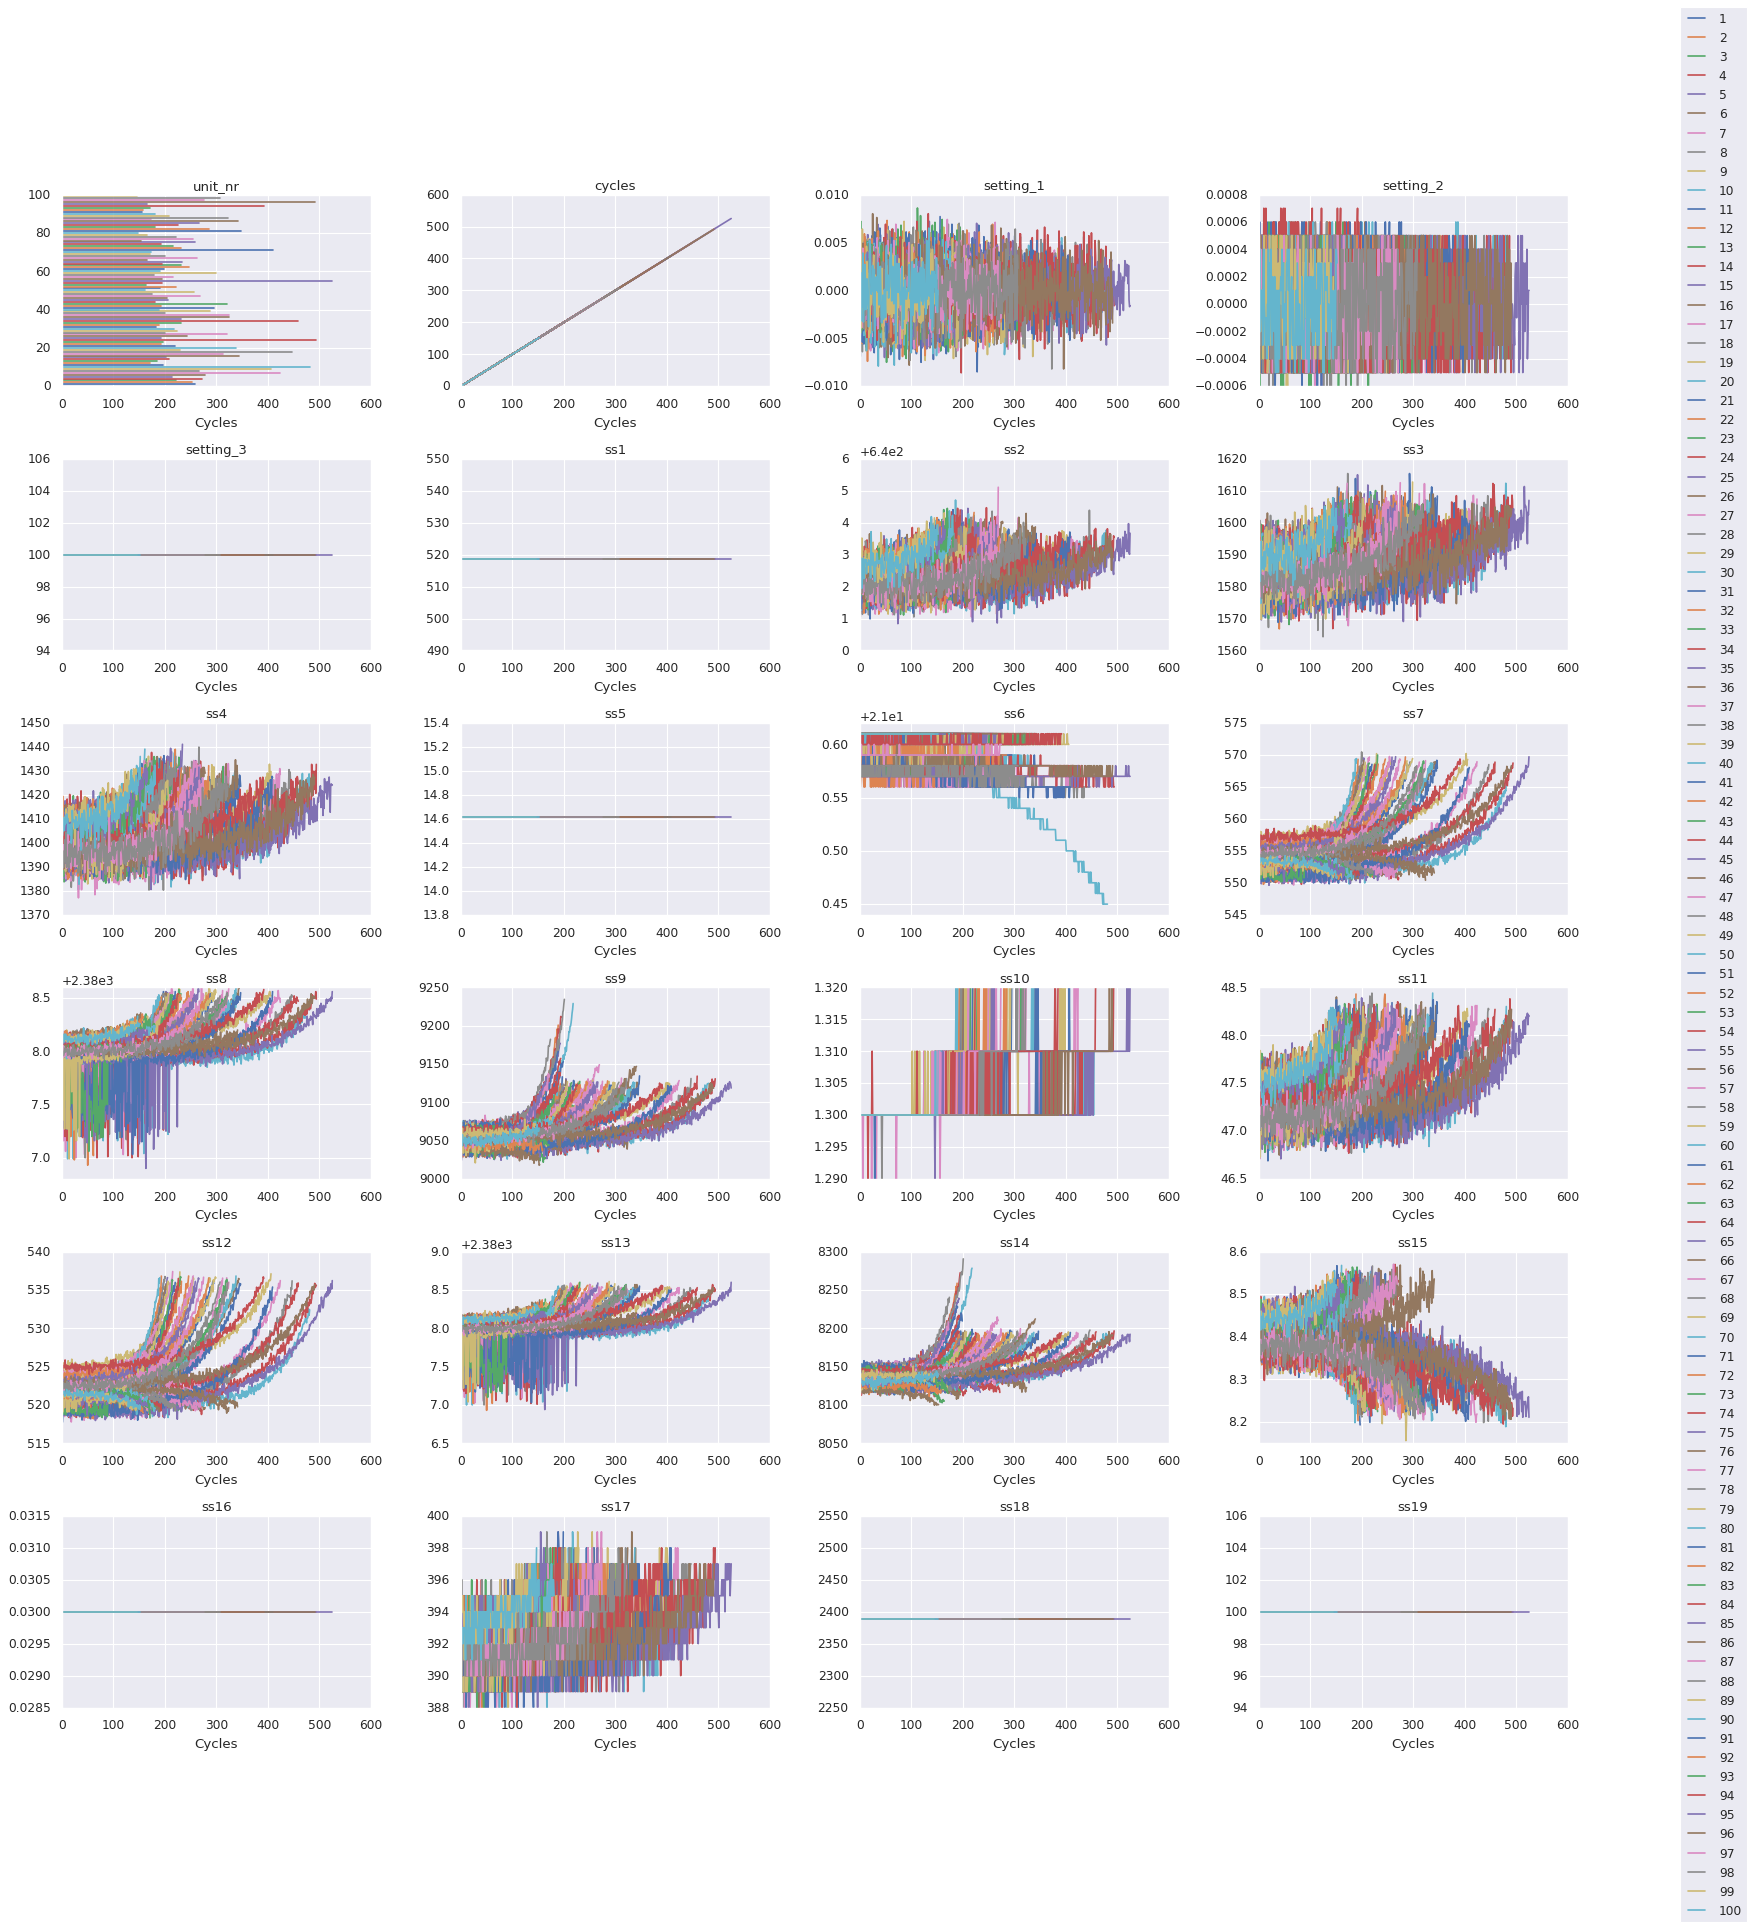

In [274]:
fig, axes = plt.subplots(6,4,figsize = (20,20))
axes = axes.flatten()
for i, (column, ax) in enumerate(zip(df_FD003.columns, axes)):
  for i in df_FD003['unit_nr'].unique():
    ax.plot('cycles',column,data=df_FD003[df_FD003['unit_nr'] == i])
    ax.set_title(column)
    ax.set_xlabel('Cycles')

# Remove any unused subplots
if len(df_FD003.columns) < len(axes):
    for ax in axes[len(df_FD003.columns):]:
        ax.remove()

# Get the handles and labels from all subplots - all subplot have the same legend
handles,labels = axes[0].get_legend_handles_labels()

# Create a common legend outside of the subplots
fig.legend(handles, df_FD003['unit_nr'].unique().tolist(), loc='center left', bbox_to_anchor=(1.05, 0.5))

fig.tight_layout()

plt.savefig('filename.png', transparent=True)
plt.show()

PLot for columns for all units

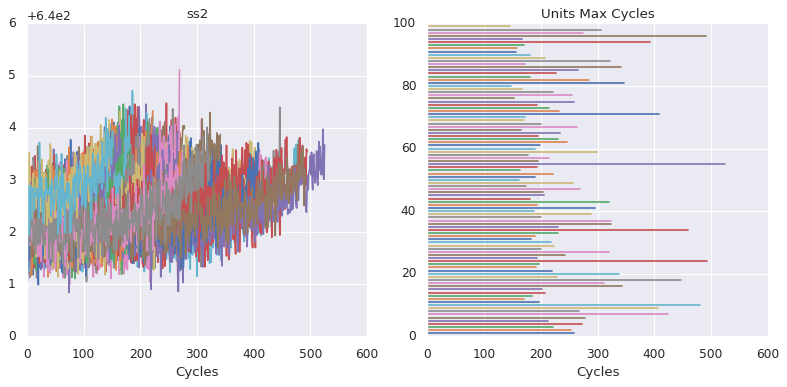

In [275]:
# PLot only some
fig,ax = plt.subplots(1,2,figsize = (10,5))
for i in df_FD003['unit_nr'].unique():
    ax[0].plot('cycles','ss2',data=df_FD003[df_FD003['unit_nr'] == i])
    ax[0].set_title('ss2')
    ax[0].set_xlabel('Cycles')

for i in df_FD003['unit_nr'].unique():
    ax[1].plot('cycles','unit_nr',data=df_FD003[df_FD003['unit_nr'] == i])
    ax[1].set_title('Units Max Cycles')
    ax[1].set_xlabel('Cycles')

fig.tight_layout()

plt.savefig('filename.png')
plt.show()

Plot for 1 units with some columns

Unit 65


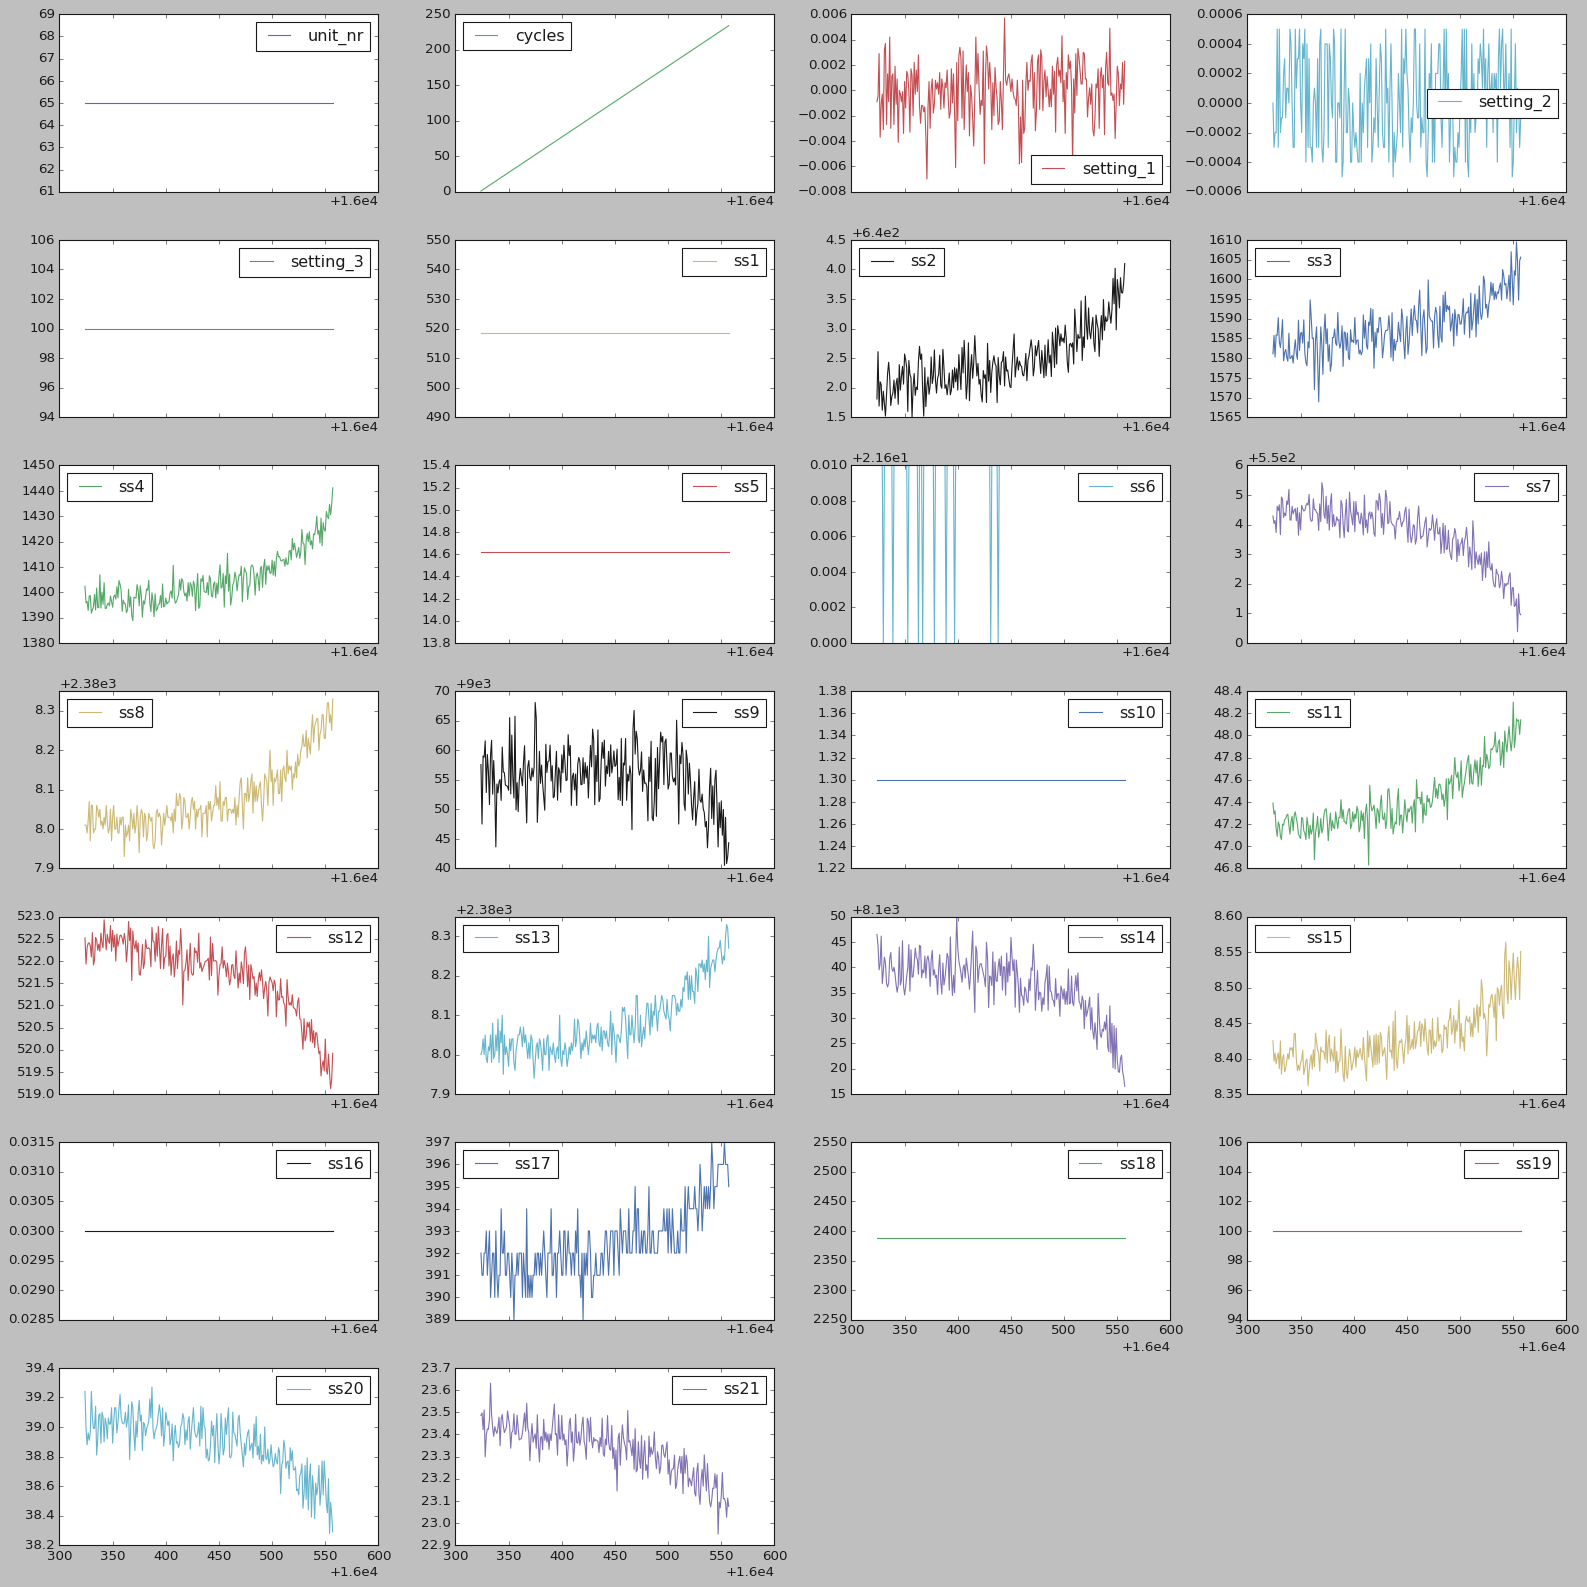

In [288]:
import numpy as np
unit_ran = np.random.randint(len(df_FD003['unit_nr'].unique()))
print('Unit {}'.format(unit_ran))
df_FD003[df_FD003['unit_nr'] == unit_ran].plot(subplots = True, figsize = (20,20), layout = (7,4))

plt.tight_layout()
plt.style.use('classic')
plt.show()

## Create HI in dataset
Use: df_drop

Out : df_HI

In [277]:
# Calculate RUL. Each engine have n-cycles. Calculate max cycle to get RUL of each engine (max - current)cycle
def add_rul(df,mode = 'HI'):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    MAX = grouped_by_unit["cycles"].max()

    # Merge the max cycle back into the original frame
    result_frame = df.merge(MAX.to_frame(name='MAX'), left_on='unit_nr', right_index=True)

    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["MAX"] - result_frame["cycles"]
    result_frame["RUL"] = remaining_useful_life
    # Add HI
    result_frame['HI'] = (remaining_useful_life / result_frame['MAX']) * 100

    # drop MAX as it's no longer needed
    if mode == 'HI':
      result_frame = result_frame.drop(["MAX",'RUL'], axis=1)
    elif mode == 'RUL':
      result_frame = result_frame.drop(["MAX",'HI'], axis=1)
    elif mode == 'MAX':
      result_frame = result_frame.drop(["RUL",'HI'], axis=1)
    return result_frame


GLOBALVALUE['RULMODE'] = 'HI'
# The mode is define in global varible, in 'FOLDER PATHS'
df_HI = add_rul(df_FD003,mode = GLOBALVALUE['RULMODE'])
df_HI.head(15)

unit_nr  cycles  setting_1  setting_2  setting_3     ss1     ss2      ss3  \
0         1       1    -0.0005     0.0004      100.0  518.67  642.36  1583.23   
1         1       2     0.0008    -0.0003      100.0  518.67  642.50  1584.69   
2         1       3    -0.0014    -0.0002      100.0  518.67  642.18  1582.35   
3         1       4    -0.0020     0.0001      100.0  518.67  642.92  1585.61   
4         1       5     0.0016     0.0000      100.0  518.67  641.68  1588.63   
5         1       6     0.0011    -0.0005      100.0  518.67  642.24  1584.09   
6         1       7    -0.0038     0.0002      100.0  518.67  642.58  1585.61   
7         1       8    -0.0007    -0.0005      100.0  518.67  642.32  1588.32   
8         1       9    -0.0026     0.0000      100.0  518.67  641.64  1587.81   
9         1      10     0.0019    -0.0002      100.0  518.67  642.42  1587.39   
10        1      11     0.0026    -0.0002      100.0  518.67  642.28  1582.38   
11        1      12    -0.0036    -0.0004      100.0  518.67  641.88  1583.24   
12        1      13    -0.0011     0.0001      100.0  518.67  641.92  1589.68   
13        1      14     0.0009     0.0001      100.0  518.67  642.66  1587.29   
14        1      15    -0.0050     0.0004      100.0  518.67  642.34  1580.80   

        ss4    ss5  ...     ss13     ss14    ss15  ss16  ss17  ss18   ss19  \
0   1396.84  14.62  ...  2388.01  8145.32  8.4246  0.03   391  2388  100.0   
1   1396.89  14.62  ...  2388.03  8152.85  8.4403  0.03   392  2388  100.0   
2   1405.61  14.62  ...  2388.00  8150.17  8.3901  0.03   391  2388  100.0   
3   1392.27  14.62  ...  2388.08  8146.56  8.3878  0.03   392  2388  100.0   
4   1397.65  14.62  ...  2388.03  8147.80  8.3869  0.03   392  2388  100.0   
5   1400.01  14.62  ...  2388.02  8144.92  8.4152  0.03   393  2388  100.0   
6   1401.09  14.62  ...  2388.02  8147.05  8.3842  0.03   391  2388  100.0   
7   1397.08  14.62  ...  2387.97  8157.34  8.4190  0.03   391  2388  100.0   
8   1406.51  14.62  ...  2388.01  8147.20  8.4091  0.03   392  2388  100.0   
9   1402.25  14.62  ...  2387.99  8152.86  8.3987  0.03   391  2388  100.0   
10  1391.88  14.62  ...  2388.03  8144.53  8.4235  0.03   392  2388  100.0   
11  1397.74  14.62  ...  2387.98  8149.04  8.3590  0.03   392  2388  100.0   
12  1395.55  14.62  ...  2388.02  8151.88  8.3821  0.03   391  2388  100.0   
13  1400.90  14.62  ...  2387.97  8148.13  8.4277  0.03   390  2388  100.0   
14  1396.50  14.62  ...  2388.00  8150.63  8.4007  0.03   390  2388  100.0   

     ss20     ss21         HI  
0   39.11  23.3537  99.613900  
1   38.99  23.4491  99.227799  
2   38.85  23.3669  98.841699  
3   38.96  23.2951  98.455598  
4   39.14  23.4583  98.069498  
5   38.92  23.4281  97.683398  
6   38.84  23.4087  97.297297  
7   39.05  23.4590  96.911197  
8   38.99  23.4693  96.525097  
9   38.94  23.4781  96.138996  
10  38.97  23.4127  95.752896  
11  39.09  23.3660  95.366795  
12  39.04  23.4273  94.980695  
13  39.03  23.3860  94.594595  
14  39.02  23.4556  94.208494  

[15 rows x 27 columns]

Check plot histogram of RUL. From 100 engine !

How The RUL is distribute

Most engine have 200 Max cycle

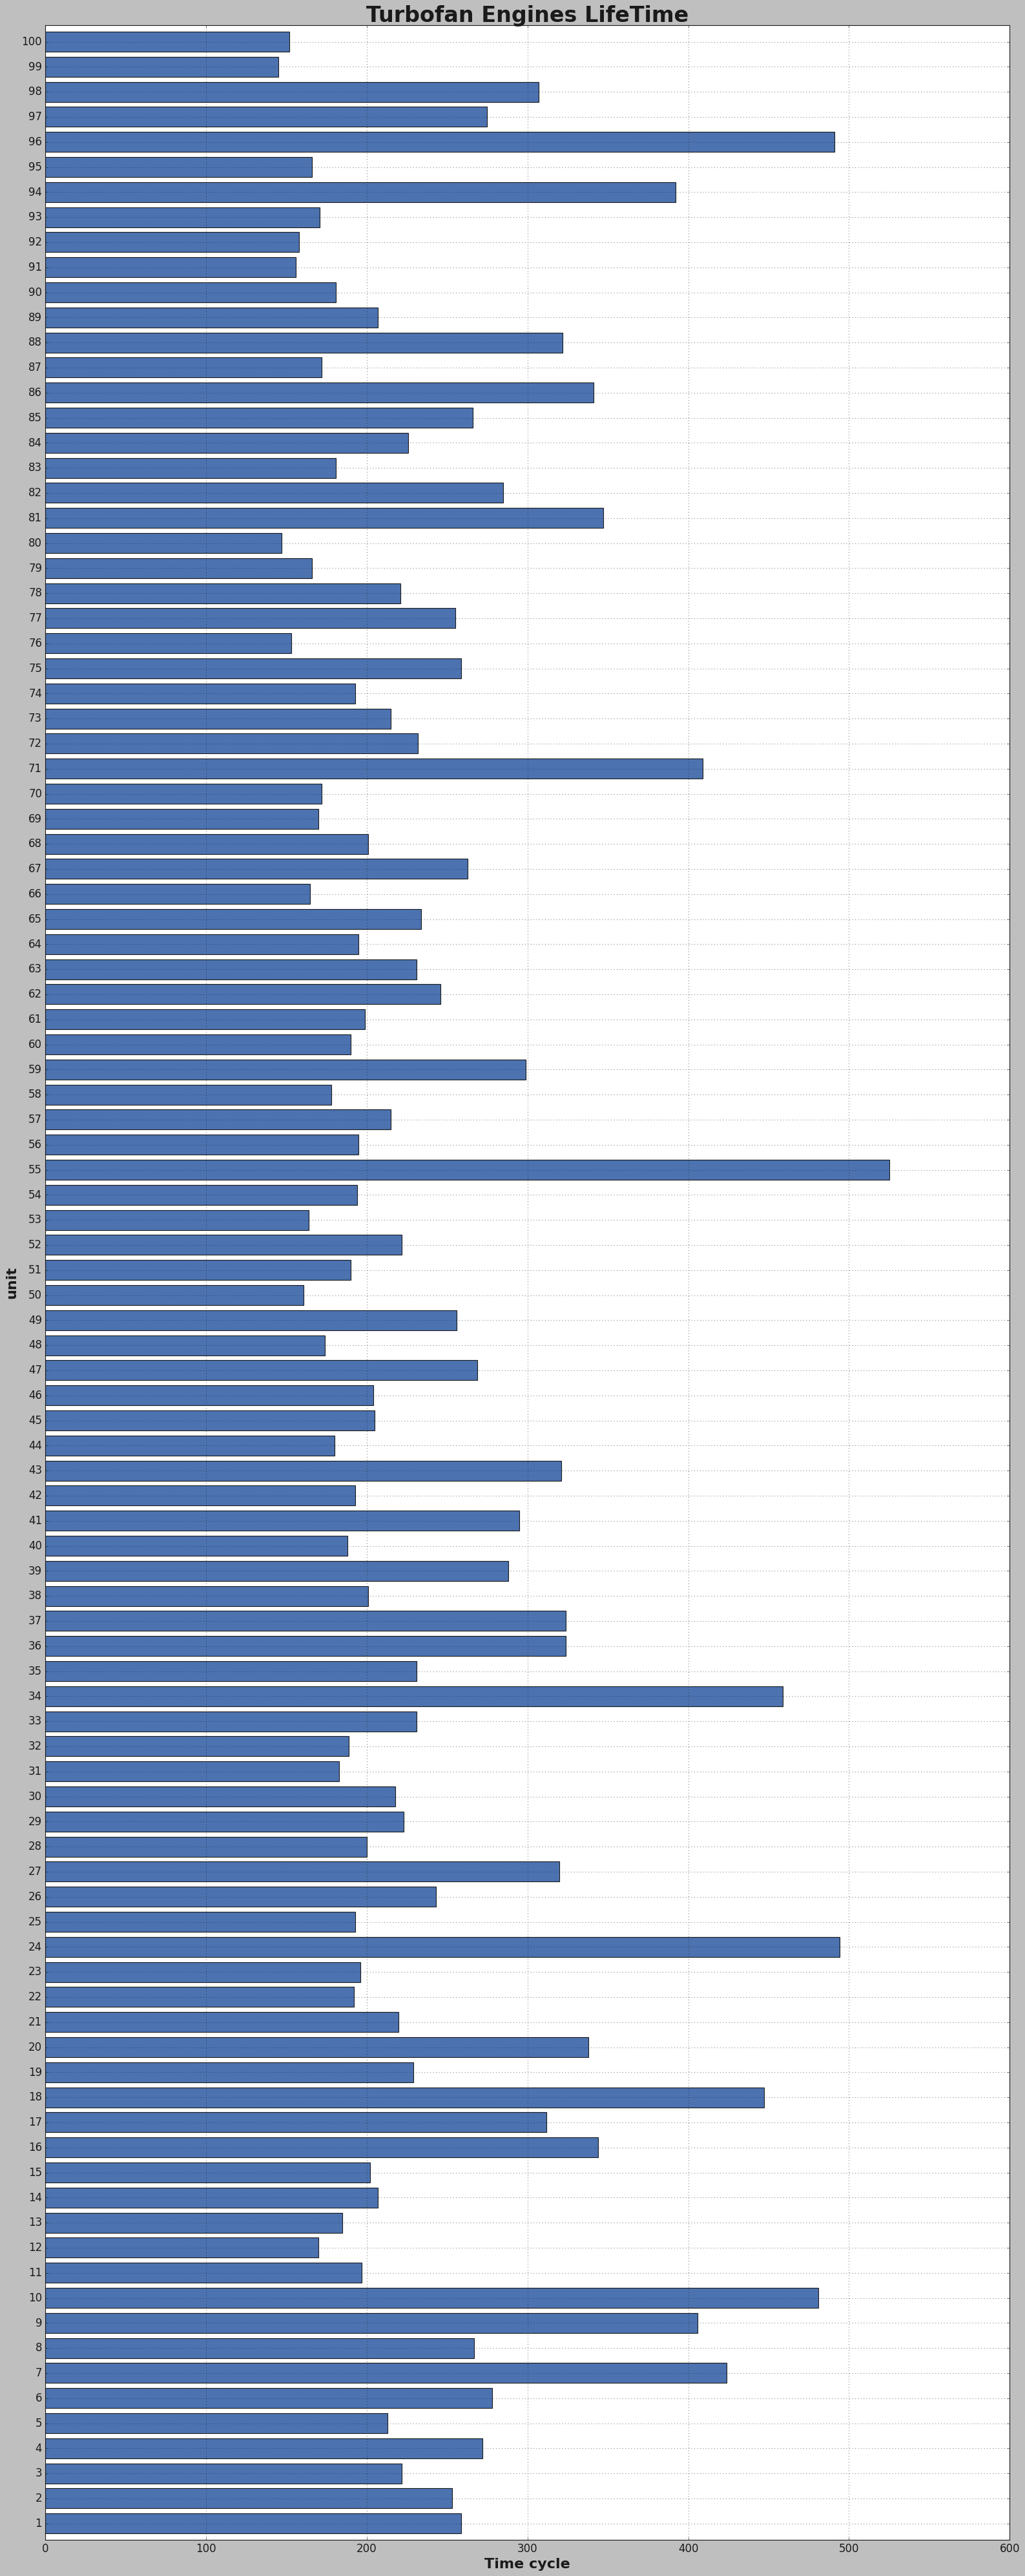

In [278]:
max_time_cycles=df_HI[['unit_nr','cycles']].groupby('unit_nr').max()
plt.figure(figsize=(20,50))
ax=max_time_cycles['cycles'].plot(kind='barh',width=0.8, stacked=True,align='center')
plt.title('Turbofan Engines LifeTime',fontweight='bold',size=30)
plt.xlabel('Time cycle',fontweight='bold',size=20)
plt.xticks(size=15)
plt.ylabel('unit',fontweight='bold',size=20)
plt.yticks(size=15)
plt.grid(True)
plt.tight_layout()
plt.show()

Text(0.5, 8.844444444444429, 'max time cycle')

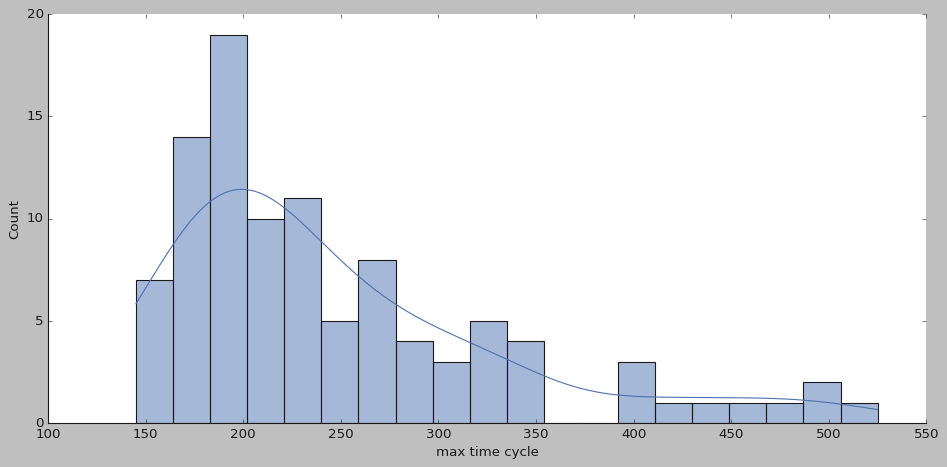

In [279]:
#Distribution of maximum time cycles
sns.displot(max_time_cycles['cycles'],kde=True,bins=20,height=6,aspect=2)
plt.xlabel('max time cycle')

## Create velocity of data
$\frac{y_2 - y_1}{x_2-x_1}$

array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >]], dtype=object)

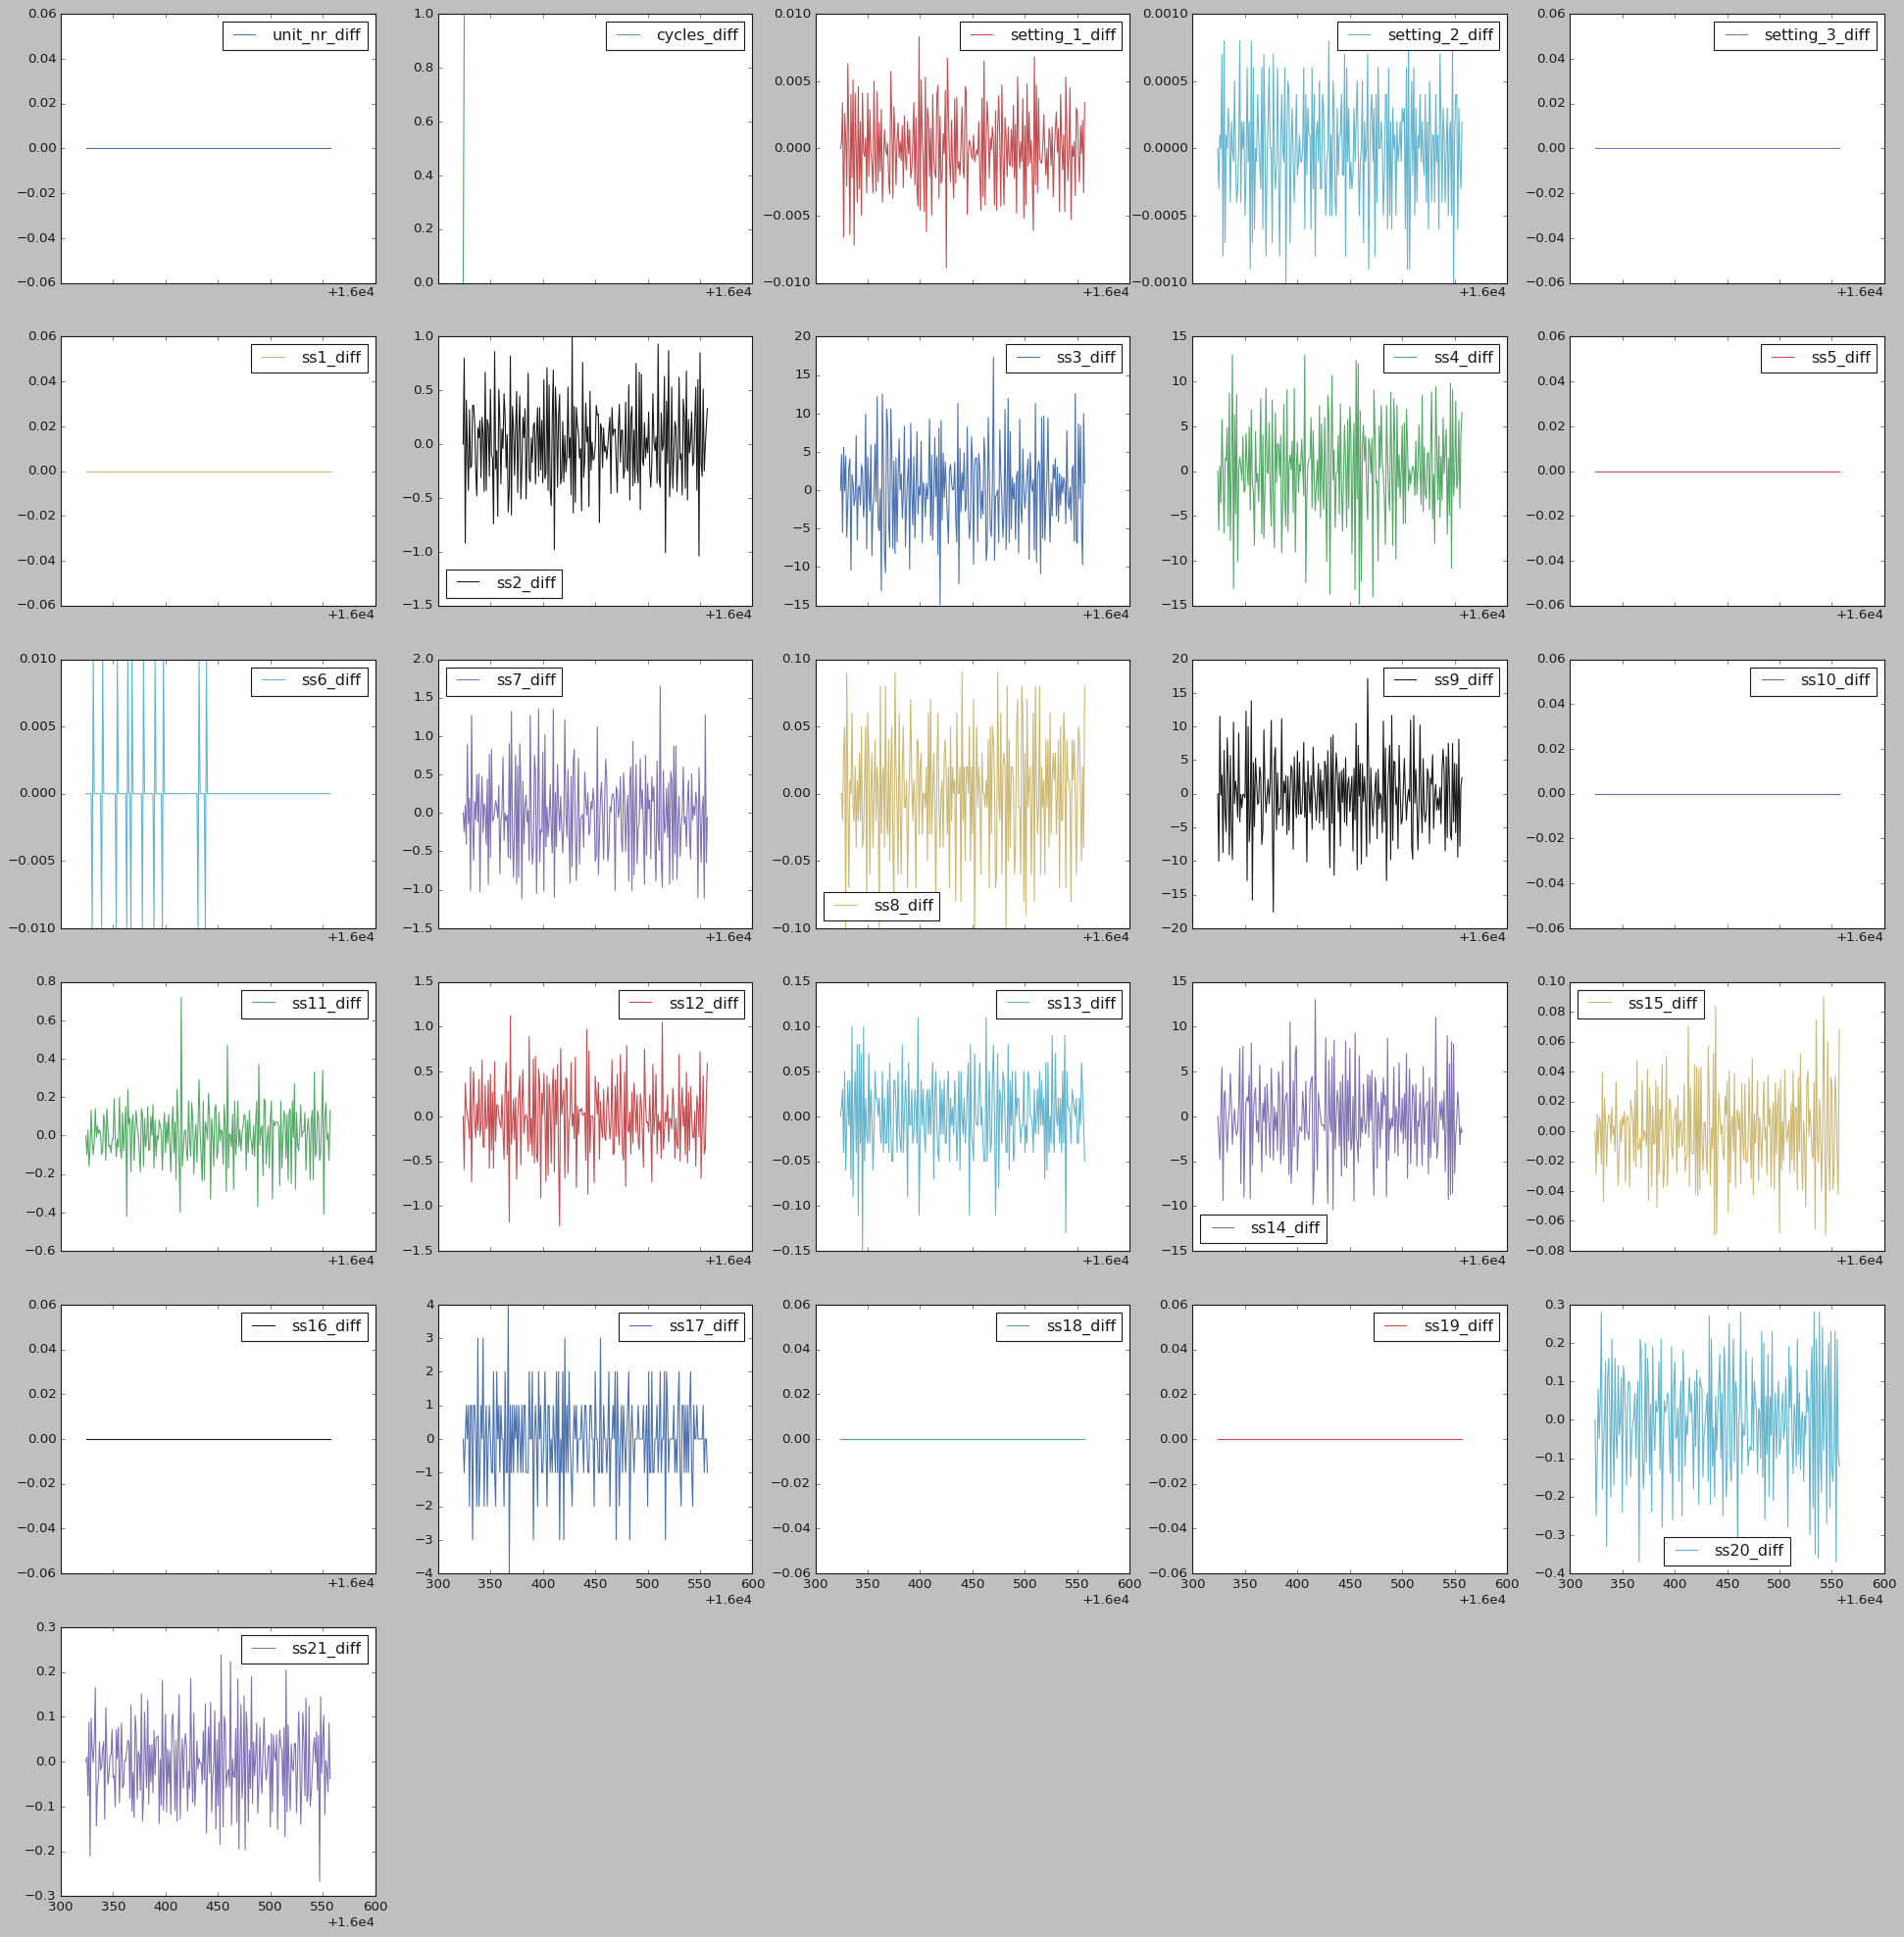

In [289]:
import pandas as pd
diff_df = pd.DataFrame()
for column in df_FD003.columns:
    diff_df[f'{column}_diff'] = df_FD003[df_FD003['unit_nr'] == 65][column].diff()
# Replace NaN values with 0
diff_df.fillna(0, inplace=True)
diff_df.plot(subplots = True,layout = (6,5), figsize = (30,30))

# Feature Engineering and Selection

## Correlation (dont use)

Use: df_HI

Out: df_corr


Drop the cycles columns since it now turn into HI

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt
def mine_showheatmap(df,threshold=None):
  if threshold == None:
    # Calculate the correlation matrix
    corr_matrix = df.corr(method = 'pearson').abs()

    # Create a heatmap using seaborn
    plt.figure(figsize=(20,10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    return corr_matrix
  else:
    corr_matrix = df.corr(method = 'pearson').abs()
    bool_matrix = corr_matrix.abs() >= threshold
    # Create a heatmap using seaborn
    plt.figure(figsize=(20,10))
    sns.heatmap(bool_matrix, annot=True, cmap='coolwarm')
    return bool_matrix

The dataset contain 100 units, however we will run on the whole dataset and consider all 100 units is the same !!!

Make dataset with important features

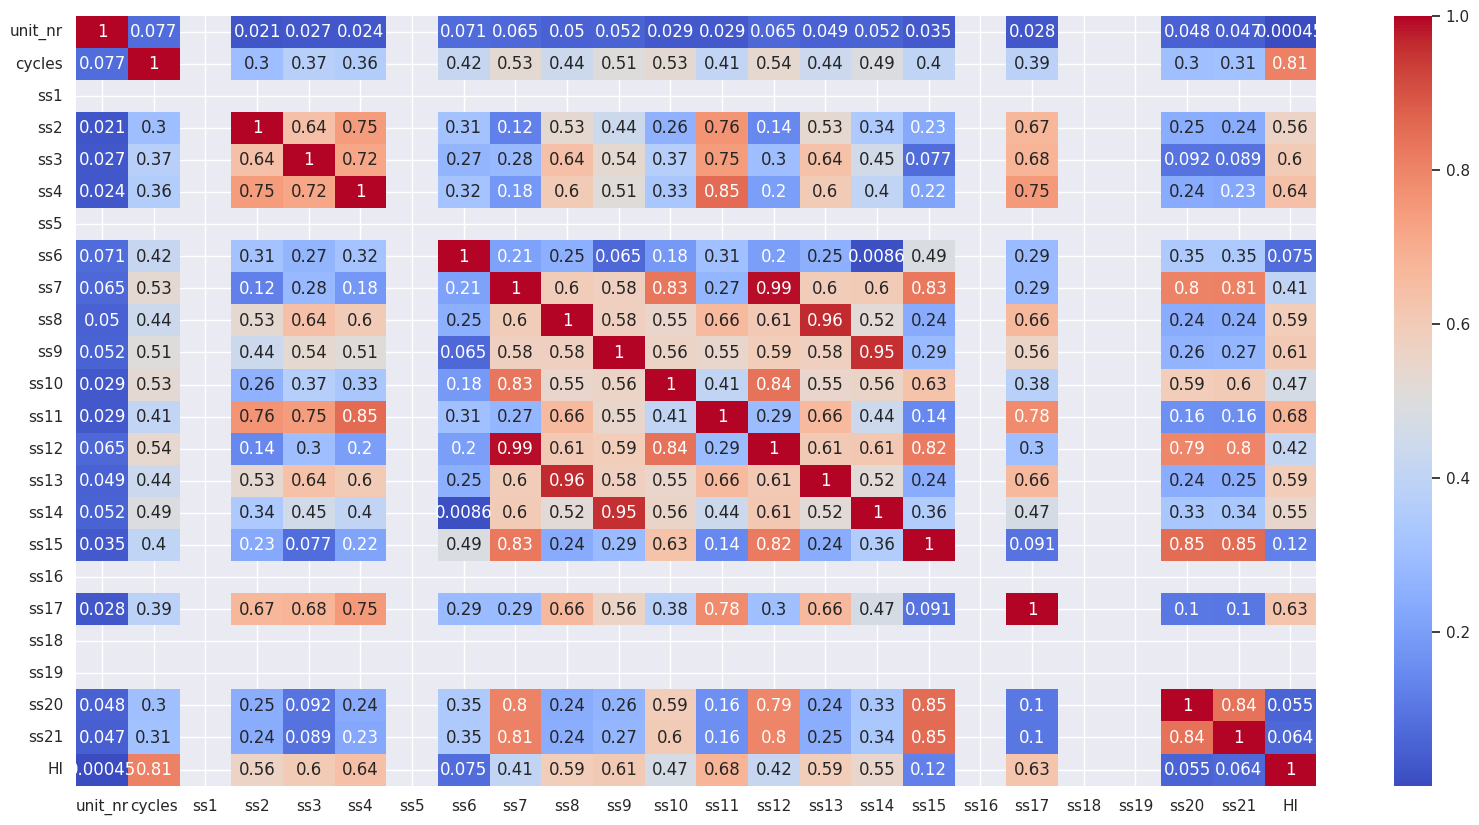

In [69]:
corr_matrix = mine_showheatmap(df_HI)

In [71]:
# With threshold, we will eliminate unrelevant data
filter_threshold = 0.5

# target column for filter
cor_target = corr_matrix['HI']
relevant_features = cor_target[cor_target > filter_threshold]
print(relevant_features)
# keep the features
df_corr = df_HI.loc[:, relevant_features.index.tolist()]
df_corr

cycles    0.808358
ss2       0.562761
ss3       0.601542
ss4       0.640321
ss8       0.592576
ss9       0.607095
ss11      0.676865
ss13      0.593276
ss14      0.546129
ss17      0.626468
HI        1.000000
Name: HI, dtype: float64


cycles     ss2      ss3      ss4      ss8      ss9   ss11     ss13  \
0           1  642.36  1583.23  1396.84  2387.96  9062.17  47.30  2388.01   
1           2  642.50  1584.69  1396.89  2388.00  9061.78  47.23  2388.03   
2           3  642.18  1582.35  1405.61  2388.03  9070.23  47.22  2388.00   
3           4  642.92  1585.61  1392.27  2388.00  9064.57  47.24  2388.08   
4           5  641.68  1588.63  1397.65  2388.04  9076.14  47.15  2388.03   
...       ...     ...      ...      ...      ...      ...    ...      ...   
24715     148  643.78  1596.01  1424.11  2388.25  9070.82  48.27  2388.30   
24716     149  643.29  1596.38  1429.14  2388.23  9064.60  48.13  2388.28   
24717     150  643.84  1604.53  1431.41  2388.25  9063.45  48.18  2388.24   
24718     151  643.94  1597.56  1426.57  2388.26  9062.22  48.05  2388.26   
24719     152  643.64  1599.04  1436.06  2388.26  9066.52  48.12  2388.24   

          ss14  ss17         HI  
0      8145.32   391  99.613900  
1      8152.85   392  99.227799  
2      8150.17   391  98.841699  
3      8146.56   392  98.455598  
4      8147.80   392  98.069498  
...        ...   ...        ...  
24715  8138.08   394   2.631579  
24716  8144.36   395   1.973684  
24717  8135.95   396   1.315789  
24718  8141.24   395   0.657895  
24719  8136.98   396   0.000000  

[24720 rows x 11 columns]

## Simple Drop

Use: df_HI

Out: df_drop

array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >]], dtype=object)

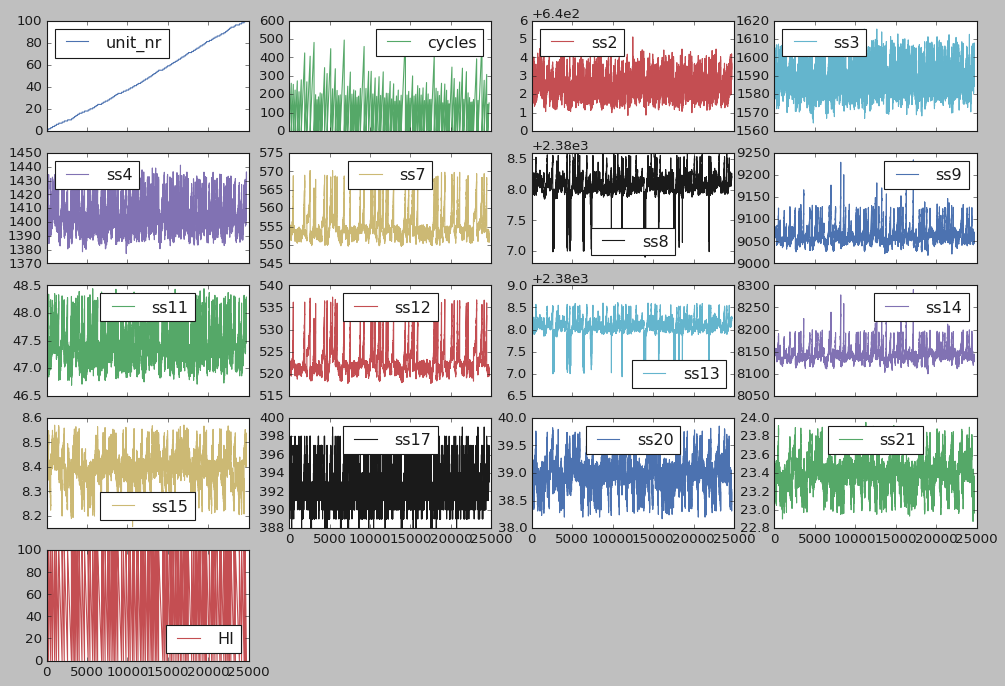

In [247]:
# Remove setting collunms
try:
  df_drop = df_HI.drop(['setting_1','setting_2','setting_3'],axis = 1)
except:
  print('Already drop !!')

drop_list = ['ss1','ss5','ss6','ss10','ss16','ss18','ss19',]
df_drop = df_drop.drop(drop_list,axis = 1)
df_drop.plot(subplots = True,figsize = (15,10),layout = (5,4))

## Split units

Use random 21 set for building model, 79 units for testing

Use: df_drop

Out:
* df_build
* df_utest

In [252]:
build_list = []
num_select = 21
for i in range(0,num_select):
  build_list.append(np.random.randint(100))

print('Units got selected: {}'.format(build_list))
print('Len: {}'.format(len(build_list)))

Units got selected: [83, 48, 72, 67, 85, 43, 68, 20, 51, 23, 56, 27, 50, 73, 97, 10, 74, 59, 29, 24, 49]
Len: 21


In [253]:
df_build = df_drop[df_drop['unit_nr'].isin(build_list)].reset_index(drop=True)
df_utest = df_drop[~df_drop['unit_nr'].isin(build_list)].reset_index(drop=True)

Check each units

array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >]], dtype=object)

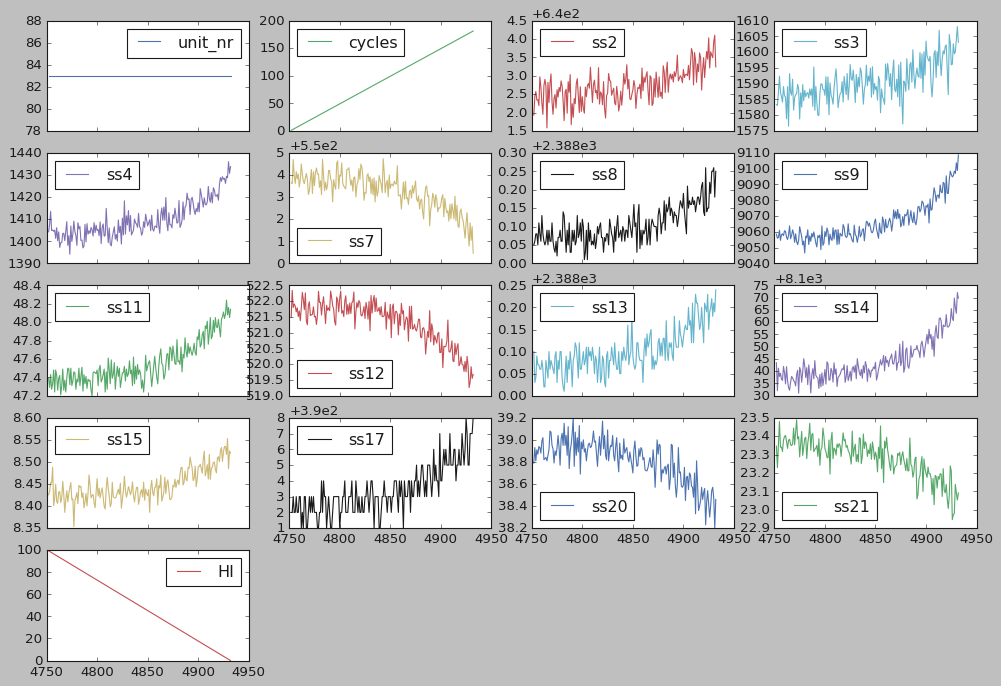

In [254]:
i = build_list[0]
df_build[df_build['unit_nr'] == i].plot(subplots=True, layout=(5,4),figsize=(15,10))

### The new histogram of the build

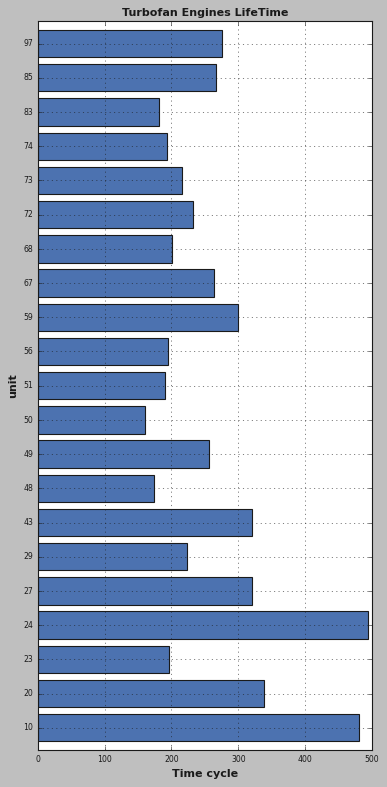

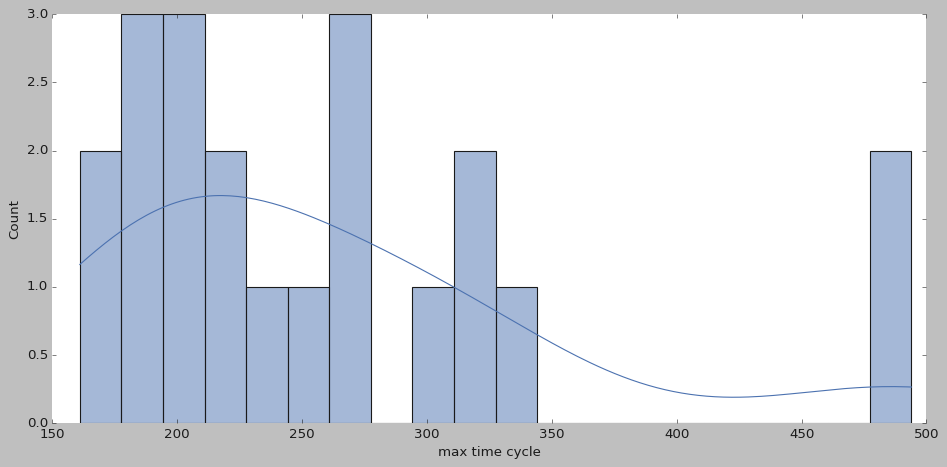

In [255]:
max_time_cycles_build=df_build[['unit_nr','cycles']].groupby('unit_nr').max()
plt.figure(figsize=(5,10))
ax=max_time_cycles_build['cycles'].plot(kind='barh',width=0.8, stacked=True,align='center')
plt.title('Turbofan Engines LifeTime',fontweight='bold',size=10)
plt.xlabel('Time cycle',fontweight='bold',size=10)
plt.xticks(size=7)
plt.ylabel('unit',fontweight='bold',size=10)
plt.yticks(size=7)
plt.grid(True)
plt.tight_layout()
plt.show()

#Distribution of maximum time cycles
sns.displot(max_time_cycles_build['cycles'],kde=True,bins=20,height=6,aspect=2)
plt.xlabel('max time cycle')
for spine in plt.gca().spines.values():
    spine.set_visible(False)

### Histogram of the test

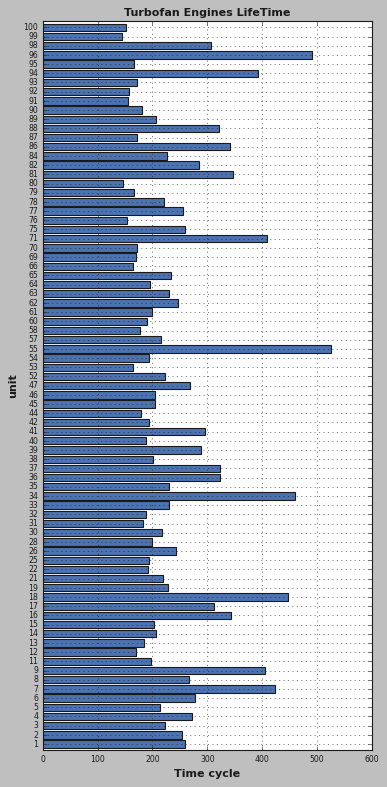

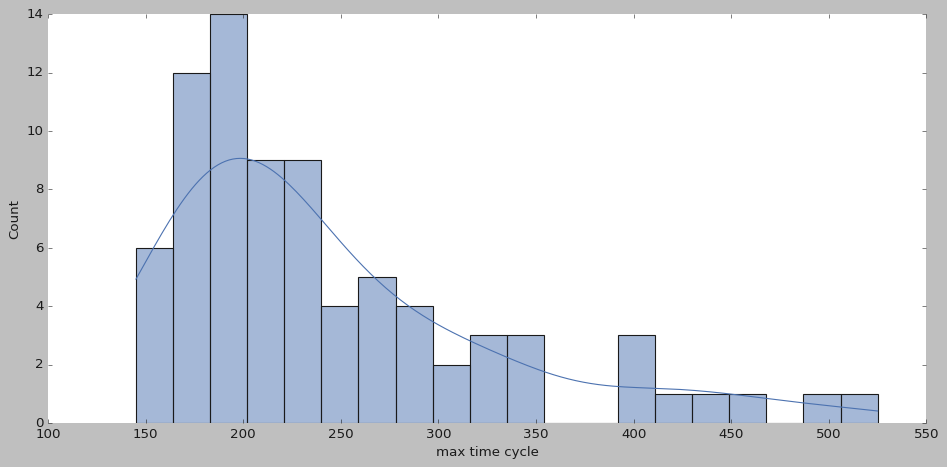

In [256]:
max_time_cycles_utest=df_utest[['unit_nr','cycles']].groupby('unit_nr').max()
plt.figure(figsize=(5,10))
ax=max_time_cycles_utest['cycles'].plot(kind='barh',width=0.8, stacked=True,align='center')
plt.title('Turbofan Engines LifeTime',fontweight='bold',size=10)
plt.xlabel('Time cycle',fontweight='bold',size=10)
plt.xticks(size=7)
plt.ylabel('unit',fontweight='bold',size=10)
plt.yticks(size=7)
plt.grid(True)
plt.tight_layout()
plt.show()

#Distribution of maximum time cycles
sns.displot(max_time_cycles_utest['cycles'],kde=True,bins=20,height=6,aspect=2)
plt.xlabel('max time cycle')
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# FORMAT
We will build multiple model for each units set. There for each units set will format seperately

## Main funtion

In [234]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

class mine_formatting():
  ###########---------- NORMALIZER ----------##########
  class mine_normalizer:
    def __init__(self,df):
      self.df = df.copy()

    def min_max_scaler(self):
      scaler = MinMaxScaler()
      norm_data = scaler.fit_transform(self.df)
      norm_df = pd.DataFrame(norm_data, columns=self.df.columns)
      return norm_df

    def standard_scaler(self):
      scaler = StandardScaler()
      norm_data = scaler.fit_transform(self.df)
      norm_df = pd.DataFrame(norm_data, columns=self.df.columns)
      return norm_df

    def normalize(self):
      scaler = Normalizer()
      norm_data = scaler.fit_transform(self.df)
      norm_df = pd.DataFrame(norm_data, columns=self.df.columns)
      return norm_df

  class train_test_val_split:
    def __init__(self,df):
      self.df = df
      try:
        self.df = self.df.drop(['unit_nr','cycles'],axis = 1)
      except:
        print('Already drop unit_nr and cycles')

    def split(self,train_size=0.7, val_size=0.15, test_size=0.15):
      train_val, test = train_test_split(self.df, test_size=test_size, shuffle=False)
      train, val = train_test_split(train_val, test_size=val_size / (train_size + val_size), shuffle=False)

      num_cols = self.df.shape[1]  # Number of columns in the dataset

      if num_cols == 1:  # Univariate data
          plt.figure(figsize=(10, 6))
          plt.plot(train, label='Train')
          plt.plot(test, label='Test')
          plt.plot(val, label='Val')
          plt.title('Train/test split with threshold: Train-{}, Val-{}, Test-{}'.format(train_size, val_size, test_size))
          plt.legend()
          plt.show()
      else:  # Multivariate data
          num_rows = (num_cols + 2) // 3  # Calculate the number of subplot rows
          fig, axes = plt.subplots(num_rows, 3, figsize=(15, 6 * num_rows))
          plt.title('Train/test split with threshold: Train-{}, Val-{}, Test-{}'.format(train_size, val_size, test_size))

          for i, columns in enumerate(self.df.columns):
              row = i // 3
              col = i % 3
              axes[row, col].plot(train.iloc[:, i], label='Train')
              axes[row, col].plot(test.iloc[:, i], label='Test')
              axes[row, col].plot(val.iloc[:, i], label='Val')
              axes[row, col].set_title(self.df.columns[i])
              axes[row, col].legend()

          # Remove unused subplots
          if num_cols % 3 != 0:
              for j in range(num_cols % 3, 3):
                  fig.delaxes(axes[num_rows - 1, j])

          plt.show()
      return train, val, test

In [230]:
###########---------- STORAGE ----------##########
class mine_df_storage:
  def __init__(self,unit_nr,df_unit):
    self.unit_nr = unit_nr
    self.df_unit = df_unit
    self.df_nor = mine_formatting.mine_normalizer(self.df_unit).min_max_scaler()
    train, val, test = mine_formatting.train_test_val_split(self.df_nor).split()
    self.df_train = train
    self.df_val = val
    self.df_test = test

## Normalize and train test val split storages

In [258]:
df_build['unit_nr'].unique()

array([10, 20, 23, 24, 27, 29, 43, 48, 49, 50, 51, 56, 59, 67, 68, 72, 73,
       74, 83, 85, 97])

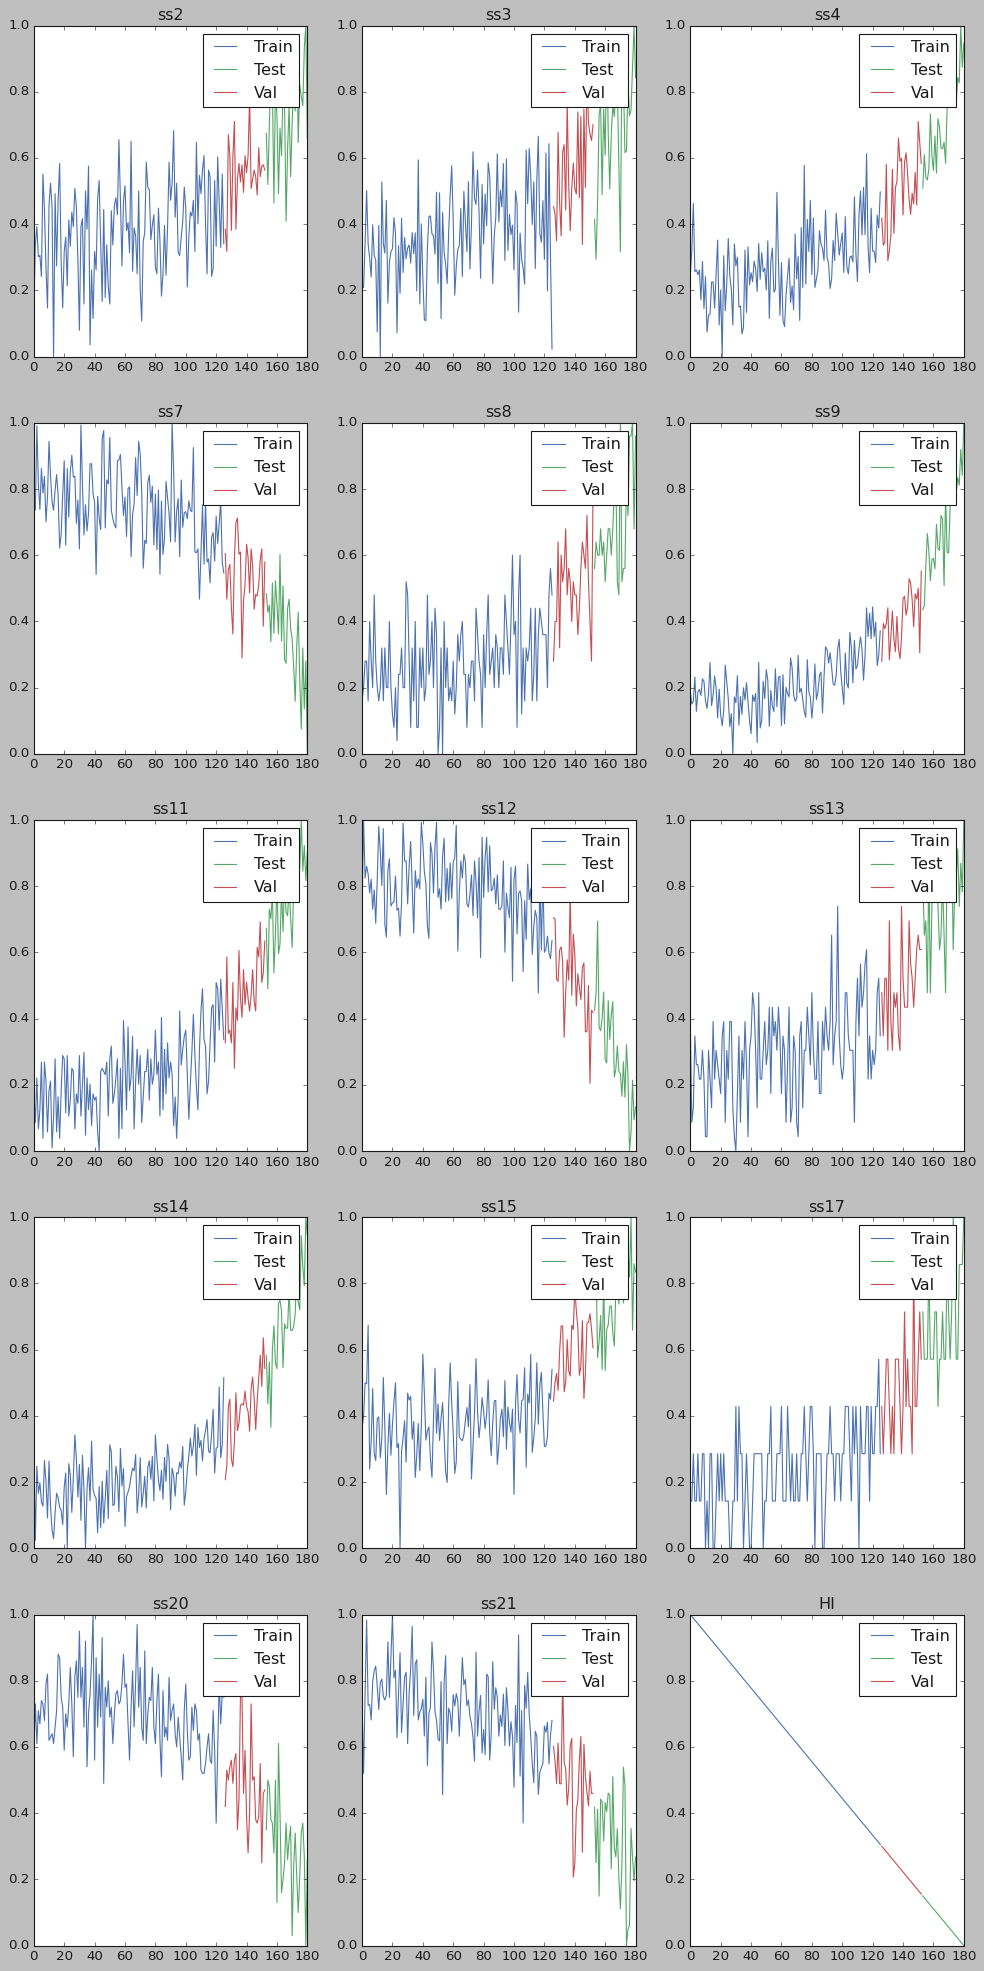

In [257]:
unit_choose = df_build[df_build['unit_nr'] == build_list[0]]
df_unit = []

df_unit.append(mine_df_storage(
    unit_nr = 12,
    df_unit = unit_choose
))

In [259]:
# Check atribute and it value
df_unit[0].__dict__

{'unit_nr': 12,
 'df_unit':       unit_nr  cycles     ss2      ss3      ss4     ss7      ss8      ss9  \
 4752       83       1  641.93  1583.34  1404.29  553.65  2388.05  9058.42   
 4753       83       2  642.43  1583.08  1407.62  553.61  2388.06  9055.91   
 4754       83       3  642.57  1587.34  1413.53  554.70  2388.08  9056.41   
 4755       83       4  642.34  1592.35  1404.85  553.95  2388.08  9060.99   
 4756       83       5  642.35  1587.24  1405.09  553.62  2388.05  9054.55   
 ...       ...     ...     ...      ...      ...     ...      ...      ...   
 4928       83     177  643.56  1599.48  1429.45  550.78  2388.25  9098.45   
 4929       83     178  643.49  1600.05  1428.76  551.83  2388.25  9097.07   
 4930       83     179  643.93  1604.12  1436.03  551.04  2388.26  9103.75   
 4931       83     180  644.10  1608.09  1430.75  551.66  2388.18  9098.88   
 4932       83     181  643.24  1603.11  1433.78  550.46  2388.25  9108.75   
 
        ss11    ss12     ss13     s

## Windowlize

In [ ]:
import tensorflow as tf

class Windowlize():
  def __init__(self, input_size, output_size, offset,
               df_train, df_val, df_test,
               target_col=None):
    # Store the raw data.
    self.df_train = df_train
    self.df_val = df_val
    self.df_test = df_test

    # Work out the label column indices.
    self.target_col = target_col
    if target_col is not None:
      self.target_col_indices = {name: i for i, name in
                                    enumerate(target_col)}
    self.column_indices = {name: i for i, name in
                           enumerate(df_train.columns)}

    # Work out the window parameters.
    self.input_size = input_size
    self.output_size = output_size
    self.offset = offset

    self.window_size = input_size + offset
    self.input_slice = slice(0, input_size)
    self.input_indices = np.arange(self.window_size)[self.input_slice]

    self.label_start = self.window_size - self.output_size
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.window_size)[self.labels_slice]

    print('\n'.join([
        f'Total window size: {self.window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.target_col}']))


  def split_window(self, features):
    inputs = []
    labels = []
    print(features)

    inputs = features[:, :self.input_size]
    labels = features[:, -self.output_size:]

    inputs = tf.convert_to_tensor(inputs)
    labels = tf.convert_to_tensor(labels)

    if self.target_col is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.target_col],
          axis=-1)

    inputs.set_shape([None, self.input_size, None])
    labels.set_shape([None, self.output_size, None])

    return inputs, labels

  # def split_window(self, features):
  #   inputs = features[:, self.input_slice, :]
  #   labels = features[:, self.labels_slice, :]
  #   if self.target_col is not None:
  #     labels = tf.stack(
  #         [labels[:, :, self.column_indices[name]] for name in self.target_col],
  #         axis=-1)

  #   # Slicing doesn't preserve static shape information, so set the shapes
  #   # manually. This way the `tf.data.Datasets` are easier to inspect.
  #   inputs.set_shape([None, self.input_size, None])
  #   labels.set_shape([None, self.output_size, None])

  #   return inputs, labels

  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=1,)

    ds = ds.map(self.split_window)
    return ds

  @property
  def train(self):
    return self.make_dataset(self.df_train)

  @property
  def val(self):
    return self.make_dataset(self.df_val)

  @property
  def test(self):
    return self.make_dataset(self.df_test)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)
  return ds

In [ ]:
w1 = Windowlize(input_size = 1, output_size = 1, offset = 2,
               df_train =  train, df_val = val, df_test = test,
               target_col=['HI'])

Total window size: 4
Input indices: [0]
Label indices: [3]
Label column name(s): ['HI']


In [ ]:
w1.train

Tensor("args_0:0", shape=(None, None, 15), dtype=float32)


<_MapDataset element_spec=(TensorSpec(shape=(None, 1, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))>

In [ ]:
for input,output in w1.train.take(1):
  X_train = input
  y_train = output
train,X_train, y_train

Tensor("args_0:0", shape=(None, None, 15), dtype=float32)


(          ss2       ss3       ss4       ss7       ss8       ss9      ss11  \
 0    0.232210  0.243664  0.093615  0.800000  0.233333  0.156009  0.000000   
 1    0.205993  0.336118  0.135651  0.852174  0.133333  0.103336  0.231343   
 2    0.104869  0.372696  0.268121  0.932609  0.333333  0.148594  0.216418   
 3    0.153558  0.252592  0.202681  0.739130  0.133333  0.206827  0.126866   
 4    0.172285  0.105127  0.349012  0.928261  0.300000  0.208990  0.238806   
 ..        ...       ...       ...       ...       ...       ...       ...   
 195  0.513109  0.461118  0.486935  0.752174  0.700000  0.147977  0.373134   
 196  0.479401  0.381912  0.366508  0.700000  0.433333  0.257337  0.320896   
 197  0.726592  0.598790  0.357873  0.671739  0.366667  0.225363  0.156716   
 198  0.438202  0.339574  0.505112  0.697826  0.500000  0.261353  0.417910   
 199  0.550562  0.413306  0.434447  0.495652  0.466667  0.326846  0.380597   
 
          ss12      ss13      ss14      ss15      ss17      ss

In [ ]:
y_train_flat = tf.reshape(y_train, [-1]).numpy()
y_train_flat = np.round(y_train_flat, decimals=7)
np_train = train['HI'].to_numpy()
np_train = np.round(np_train, decimals=7)
print('Y: \n{}'.format(y_train_flat))
print('Orginal: \n{}'.format(np_train))


indices = []
for val in y_train_flat:
    match_indices = np.where(np.isclose(np_train, val))[0]
    if len(match_indices) > 0:
        indices.append(match_indices[0])
print(indices)
print(np_train[3] - y_train_flat[0])

Y: 
[0.479021]
Orginal: 
[1.        0.9965035 0.993007  0.9895105 0.986014  0.9825175 0.979021
 0.9755245 0.972028  0.9685315 0.965035  0.9615385 0.958042  0.9545455
 0.951049  0.9475524 0.9440559 0.9405594 0.9370629 0.9335664 0.9300699
 0.9265734 0.9230769 0.9195804 0.9160839 0.9125874 0.9090909 0.9055944
 0.9020979 0.8986014 0.8951049 0.8916084 0.8881119 0.8846154 0.8811189
 0.8776224 0.8741259 0.8706294 0.8671329 0.8636364 0.8601399 0.8566434
 0.8531469 0.8496503 0.8461538 0.8426573 0.8391608 0.8356643 0.8321678
 0.8286713 0.8251748 0.8216783 0.8181818 0.8146853 0.8111888 0.8076923
 0.8041958 0.8006993 0.7972028 0.7937063 0.7902098 0.7867133 0.7832168
 0.7797203 0.7762238 0.7727273 0.7692308 0.7657343 0.7622378 0.7587413
 0.7552448 0.7517483 0.7482517 0.7447552 0.7412587 0.7377622 0.7342657
 0.7307692 0.7272727 0.7237762 0.7202797 0.7167832 0.7132867 0.7097902
 0.7062937 0.7027972 0.6993007 0.6958042 0.6923077 0.6888112 0.6853147
 0.6818182 0.6783217 0.6748252 0.6713287 0.6678322 0.

# MODELS

The model will focus on Multistep predict: Multi step input - multistep output.
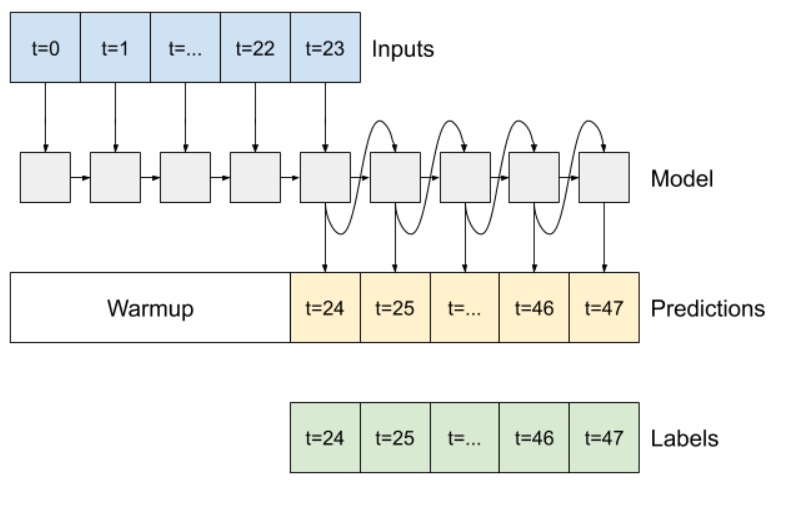

The following section with format in:
* The same performance matrix and functions
* Run for many model

Each model will consist:
* Define model
* Train
* Load
* Evalute

Model list:
* ARIMA
*

## Performance matrix and funtions

### Create score dataframe

In [ ]:
### Create the data frame for the evaluation matrix
# Same matrix can use for many regression model
df_eva = pd.DataFrame(columns=[
    'Model_name', 'MSE_mean', 'MSE_max', 'MSE_min', 'MAE_mean', 'MAE_max', 'MAE_min','Run_time'
])
df_eva

Empty DataFrame
Columns: [Model_name, MSE_mean, MSE_max, MSE_min, MAE_mean, MAE_max, MAE_min, Run_time]
Index: []

### Test set evaluate

Class 'test_evaluate' for evaluating the dataset, and save the score on the dataframe

In [ ]:
### For Test set
import time
import pandas as pd
import tensorflow as tf
import numpy as np

# Class get predction on test set and save on a dataframe 'result' for further evaluation
class test_evaluate():
  def __init__(self,model,X_test,y_test):
    self.model = model
    self.X_test = X_test
    self.y_test = y_test
    # Get reuslt: df col: {'Predictions', 'Actuals', 'mae', 'mse'}
    self.result,self.run_time = self.get_prediction()
    print(self.result)

  ### Get prediction of the dataset and return the dataset contain:['Predictions','Actuals','MAE','MSE'], with runtime
  def get_prediction(self):
    # Run prediction and get run time
    start_time = time.time()
    predict = self.model.predict(self.X_test).flatten()
    end_time = time.time()
    run_time = end_time - start_time
    # Actual value
    actual = tf.squeeze(self.y_test)
    # save in df
    result = pd.DataFrame(data={'Predictions': np.array(predict)})
    result['Actuals'] = pd.Series(actual)
    result['Error'] = np.abs(predict-actual)

    print(np.mean(result['Error']))
    return result, run_time

  def record_test(self,df,model_name):
    # get values
    predictions = tf.convert_to_tensor(self.result['Predictions'])
    actual_values = tf.convert_to_tensor(self.result['Actuals'])

    # Calculate MAE and MSE
    mse = tf.keras.losses.MSE(actual_values, predictions)
    mae = tf.keras.losses.MAE(actual_values, predictions)


    ## 'Model_name','E_mean','E_min','E_max', 'MSE', 'MAE','RMSE','Run_time'
    add_on = {
        'Model_name':[model_name],
        'E_mean':[np.mean(self.result['Error'])]  ,
        'E_min':[min(self.result['Error'])] ,
        'E_max':[max(self.result['Error'])] ,
        'MSE':[np.mean(mse.numpy())]  ,
        'MAE':[np.mean(mae.numpy())]  ,
        'RMSE':[1] ,
        'Run_time':[self.run_time]   }

    if model_name in df['Model_name'].values:
        # Remove the previous row for the same model
        df = df[df['Model_name'] != model_name]

    df_add = pd.DataFrame(add_on)
    df_new = pd.concat([df,df_add], ignore_index = True)
    df.reset_index()
    return df_new

  ### Plot out random range of the set or plot all value (if given 0) ###
  def random_plot(self,range):
    if range != 0:
      if range > (len(self.result)):
        print('ERROR: The given range > the size of the set')
        return None

      # Random
      start_index = random.randint(0, len(self.result) - range)
      end_index = start_index + range

      plt.plot(self.result['Predictions'][start_index:end_index], label='predict')
      plt.plot(self.result['Actuals'][start_index:end_index], label='actual')
      plt.xlabel('Time')
      plt.ylabel('Value')
    else:
      # All
      plt.plot(self.result['Predictions'], label='predict')
      plt.plot(self.result['Actuals'], label='actual')
      plt.xlabel('Time')
      plt.ylabel('Value')

    plt.legend()

### Training evaluate
Class 'training_error' show error during train for trainset and validate set.

Contain function:
* random_plot(range): plot a random range of value for prediction on train and validate set

In [ ]:
import random
# Plot error in training process
# Arg:
#   history: model history when train
#   model: model key
#   X_train, y_train, X_val, y_val : Datasets

class training_error:
  def __init__(self, history, model, X_train, y_train, X_val, y_val):
    self.history = history
    self.X_train = X_train
    self.y_train = y_train
    self.X_val = X_val
    self.y_val = y_val
    self.model = model

    self.result_train = self.get_prediction(self.model,self.X_train,self.y_train)
    self.result_val = self.get_prediction(self.model,self.X_val,self.y_val)

  ### Plot error of train and val set in epochs
  def training_error(self):
    # Plot error of Training and val
    train_loss = self.history.history['loss']
    val_loss = self.history.history['val_loss']

    epochs = range(1, len(train_loss) + 1)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Error Process During Training')
    plt.legend()
    plt.show()

  ### Get prediction and return the dataframe contain: 'Prediction' and 'Actual'
  def get_prediction(self,model,X,y):
    predict = self.model.predict(X).flatten()
    actual = tf.squeeze(y)

    results = pd.DataFrame(data={'Predictions': np.array(predict)})
    results['Actuals'] = pd.Series(actual)
    return results

  ### Plot for train and val set
  ### The functions have 2 mode!
    # range == 0 : the plot will show all the value in the train and val set
    # range != 0: the plot will show the random of the given range values, if the given range > the whole dataset is will error
      # note that the random in both train and val is different !!
  def random_plot(self,range):
    fig, ax = plt.subplots(1,2,figsize = (15,5))

    if range != 0:
      if range > (len(self.result_train)):
        print('ERROR: The given range > the size of the set')
        return None

      # Random part for train
      start_index = random.randint(0, len(self.result_train) - range)
      end_index = start_index + range

      ax[0].plot(self.result_train['Predictions'][start_index:end_index], label='predict')
      ax[0].plot(self.result_train['Actuals'][start_index:end_index], label='actual')
      ax[0].set_xlabel('Time')
      ax[0].set_ylabel('Value')
      # Random part for val
      start_index = random.randint(0, len(self.result_val) - range)
      end_index = start_index + range

      ax[1].plot(self.result_val['Predictions'][start_index:end_index], label='predict')
      ax[1].plot(self.result_val['Actuals'][start_index:end_index], label='actual')
      ax[1].set_ylabel('Value')
      ax[1].set_xlabel('Time')
      plt.legend()
    else:
      # All for train
      ax[0].plot(self.result_train['Predictions'], label='predict')
      ax[0].plot(self.result_train['Actuals'], label='actual')
      ax[0].set_xlabel('Time')
      ax[0].set_ylabel('Value')
      # All for val
      ax[1].plot(self.result_val['Predictions'], label='predict')
      ax[1].plot(self.result_val['Actuals'], label='actual')
      ax[1].set_ylabel('Value')
      ax[1].set_xlabel('Time')
      plt.legend()

In [ ]:
import matplotlib.pyplot as plt
def plot_data_predict(data,prediction):
  fig,ax = plt.subplots(figsize=(10,8))
  ax.plot(data, label='Data', color='blue')
  ax.plot(prediction, label='Predict',color='red')
  ax.set_ylabel('Value')
  ax.set_xlabel('TIME')
  ax.set_title('DATA - PREDICTION')
  plt.legend()

### Save model funtions
The model save will have the time save format: '%Y_%m_%d_MODELNAME.h5'
Arg:
* Project tag
* MODEL_NAME

return the paths to the save model:
the varible should be define as: "SAVE_{MODEL_NAME}"

In [ ]:
import time
def mine_save_model(project_tag,MODEL_NAME):
  # Save folder
  current_time = time.strftime("%Y_%m_%d")
  model_time_name = '%s_%s.h5'%(current_time,MODEL_NAME)
  print('-Model will save as: {}'.format(model_time_name))

  save_path = os.path.join(project_tag['SAVE_MODEL'],MODEL_NAME,model_time_name)
  print('-Path to model: {}'.format(save_path))
  return save_path

### Load model funtions
Funtions required:
* project_tag: a list contain project save paths and folder. Define in 'FOLDER PATHS' secion ex: 'CMAPSS'
* model_name: in str. ex 'LSTM'

return loaded model

In [ ]:
import glob
from natsort import natsorted
from tensorflow.keras.models import load_model

def mine_load_model(project_tag,MODEL_NAME):
  # CHOOSE MODEL TO LOAD
  model_list = natsorted(glob.glob(os.path.join(project_tag['SAVE_MODEL'],MODEL_NAME,'*')),reverse=True)
  if len(model_list) !=0:
    # print all model name
    for model in model_list:
      print('number ' + str(model_list.index(model)) + ': ' + os.path.basename(model))
    # choose the neweset model -> [0]
    choosed_model =  model_list[0]
    print('-------> Model path choose: {}'.format(choosed_model))
    # LOADING
    try:
      loaded_model = load_model(choosed_model)
      return loaded_model
    except:
      print('FAIL TO LOAD!!!!')
      return None
  else:
    print('NO MODEL TO LOAD!!')
    return None

## Linear

### Define model
Contains:
* Define model
* Create save path for the model
* Create checkpoint and early stopping for the model
* Combine the model for training

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint , EarlyStopping

from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 64)                960       
                                                                 
 dense_37 (Dense)            (None, 64)                4160      
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_38 (Dense)            (None, 1)                 65        
                                                                 
Total params: 5,185
Trainable params: 5,185
Non-trainable params: 0
_________________________________________________________________


In [ ]:
MODEL_NAME = 'Linear'
SAVE_DENSE = mine_save_model(project_tag = CMAPSS_IN, MODEL_NAME = MODEL_NAME)

-Model will save as: 2023_06_01_Dense.h5
-Path to model: /content/drive/MyDrive/ColabProjects/PdM/model/CMAPSS_instance/Dense/2023_06_01_Dense.h5


In [ ]:
# Check point
cp = ModelCheckpoint(SAVE_DENSE, save_best_only=True)
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
# Compile model
.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.00001), metrics=[RootMeanSquaredError()])

### Train
Contains:
* Fit model
* Save model
* Get train-val error during train
* Plot results of the model on the train and val set (random and all)

In [ ]:
history_dense = model_dense.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1000, callbacks=[cp, early_stopping])

Epoch 1/1000
7/7 [==============================] - 2s 44ms/step - loss: 0.1530 - root_mean_squared_error: 0.3911 - val_loss: 0.0925 - val_root_mean_squared_error: 0.3041
Epoch 2/1000
7/7 [==============================] - 0s 8ms/step - loss: 0.1302 - root_mean_squared_error: 0.3608 - val_loss: 0.0969 - val_root_mean_squared_error: 0.3113
Epoch 3/1000
7/7 [==============================] - 0s 10ms/step - loss: 0.1141 - root_mean_squared_error: 0.3377 - val_loss: 0.1013 - val_root_mean_squared_error: 0.3183
Epoch 4/1000
7/7 [==============================] - 0s 8ms/step - loss: 0.1264 - root_mean_squared_error: 0.3555 - val_loss: 0.1056 - val_root_mean_squared_error: 0.3249
Epoch 5/1000
7/7 [==============================] - 0s 9ms/step - loss: 0.1241 - root_mean_squared_error: 0.3523 - val_loss: 0.1099 - val_root_mean_squared_error: 0.3315
Epoch 6/1000
7/7 [==============================] - 0s 8ms/step - loss: 0.1120 - root_mean_squared_error: 0.3347 - val_loss: 0.1144 - val_root_mean_

In [ ]:
model_dense.save(SAVE_DENSE)

In [ ]:
te = training_error(history_dense,model_dense,X_train,y_train,X_val,y_val)

7/7 [==============================] - 0s 2ms/step
tf.Tensor(
[1.         0.9965035  0.99300699 0.98951049 0.98601399 0.98251748
 0.97902098 0.97552448 0.97202797 0.96853147 0.96503497 0.96153846
 0.95804196 0.95454545 0.95104895 0.94755245 0.94405594 0.94055944
 0.93706294 0.93356643 0.93006993 0.92657343 0.92307692 0.91958042
 0.91608392 0.91258741 0.90909091 0.90559441 0.9020979  0.8986014
 0.8951049  0.89160839 0.88811189 0.88461538 0.88111888 0.87762238
 0.87412587 0.87062937 0.86713287 0.86363636 0.86013986 0.85664336
 0.85314685 0.84965035 0.84615385 0.84265734 0.83916084 0.83566434
 0.83216783 0.82867133 0.82517483 0.82167832 0.81818182 0.81468531
 0.81118881 0.80769231 0.8041958  0.8006993  0.7972028  0.79370629
 0.79020979 0.78671329 0.78321678 0.77972028 0.77622378 0.77272727
 0.76923077 0.76573427 0.76223776 0.75874126 0.75524476 0.75174825
 0.74825175 0.74475524 0.74125874 0.73776224 0.73426573 0.73076923
 0.72727273 0.72377622 0.72027972 0.71678322 0.71328671 0.70979021
 

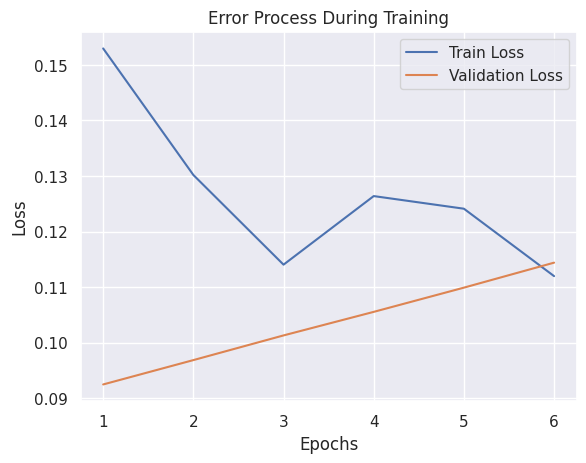

In [ ]:
te.training_error()

In [ ]:
te.random_plot(0)

### Load

In [ ]:
model_dense = mine_load_model(project_tag = CMAPSS_IN,MODEL_NAME = 'Dense')

number 0: 2023_06_01_Dense.h5
-------> Model path choose: /content/drive/MyDrive/ColabProjects/PdM/model/CMAPSS_instance/Dense/2023_06_01_Dense.h5


### Evaluate
Contains:
* Run predict on test set
* Record errors on a dataframe or further compair of difference models

## Dense

### Define model
Contains:
* Define model
* Create save path for the model
* Create checkpoint and early stopping for the model
* Combine the model for training

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint , EarlyStopping

from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [ ]:
model_dense = Sequential()
model_dense.add(Dense(64, activation='relu', input_shape=(14,)))
model_dense.add(Dense(64))
model_dense.add(Dropout(rate=0.3))
model_dense.add(Dense(1))

model_dense.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 64)                960       
                                                                 
 dense_37 (Dense)            (None, 64)                4160      
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_38 (Dense)            (None, 1)                 65        
                                                                 
Total params: 5,185
Trainable params: 5,185
Non-trainable params: 0
_________________________________________________________________


In [ ]:
MODEL_NAME = 'Dense'
SAVE_DENSE = mine_save_model(project_tag = CMAPSS_IN, MODEL_NAME = MODEL_NAME)

-Model will save as: 2023_06_01_Dense.h5
-Path to model: /content/drive/MyDrive/ColabProjects/PdM/model/CMAPSS_instance/Dense/2023_06_01_Dense.h5


In [ ]:
# Check point
cp = ModelCheckpoint(SAVE_DENSE, save_best_only=True)
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
# Compile model
model_dense.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.00001), metrics=[RootMeanSquaredError()])

### Train
Contains:
* Fit model
* Save model
* Get train-val error during train
* Plot results of the model on the train and val set (random and all)

In [ ]:
history_dense = model_dense.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1000, callbacks=[cp, early_stopping])

Epoch 1/1000
7/7 [==============================] - 2s 44ms/step - loss: 0.1530 - root_mean_squared_error: 0.3911 - val_loss: 0.0925 - val_root_mean_squared_error: 0.3041
Epoch 2/1000
7/7 [==============================] - 0s 8ms/step - loss: 0.1302 - root_mean_squared_error: 0.3608 - val_loss: 0.0969 - val_root_mean_squared_error: 0.3113
Epoch 3/1000
7/7 [==============================] - 0s 10ms/step - loss: 0.1141 - root_mean_squared_error: 0.3377 - val_loss: 0.1013 - val_root_mean_squared_error: 0.3183
Epoch 4/1000
7/7 [==============================] - 0s 8ms/step - loss: 0.1264 - root_mean_squared_error: 0.3555 - val_loss: 0.1056 - val_root_mean_squared_error: 0.3249
Epoch 5/1000
7/7 [==============================] - 0s 9ms/step - loss: 0.1241 - root_mean_squared_error: 0.3523 - val_loss: 0.1099 - val_root_mean_squared_error: 0.3315
Epoch 6/1000
7/7 [==============================] - 0s 8ms/step - loss: 0.1120 - root_mean_squared_error: 0.3347 - val_loss: 0.1144 - val_root_mean_

In [ ]:
model_dense.save(SAVE_DENSE)

In [ ]:
te = training_error(history_dense,model_dense,X_train,y_train,X_val,y_val)

7/7 [==============================] - 0s 2ms/step
tf.Tensor(
[1.         0.9965035  0.99300699 0.98951049 0.98601399 0.98251748
 0.97902098 0.97552448 0.97202797 0.96853147 0.96503497 0.96153846
 0.95804196 0.95454545 0.95104895 0.94755245 0.94405594 0.94055944
 0.93706294 0.93356643 0.93006993 0.92657343 0.92307692 0.91958042
 0.91608392 0.91258741 0.90909091 0.90559441 0.9020979  0.8986014
 0.8951049  0.89160839 0.88811189 0.88461538 0.88111888 0.87762238
 0.87412587 0.87062937 0.86713287 0.86363636 0.86013986 0.85664336
 0.85314685 0.84965035 0.84615385 0.84265734 0.83916084 0.83566434
 0.83216783 0.82867133 0.82517483 0.82167832 0.81818182 0.81468531
 0.81118881 0.80769231 0.8041958  0.8006993  0.7972028  0.79370629
 0.79020979 0.78671329 0.78321678 0.77972028 0.77622378 0.77272727
 0.76923077 0.76573427 0.76223776 0.75874126 0.75524476 0.75174825
 0.74825175 0.74475524 0.74125874 0.73776224 0.73426573 0.73076923
 0.72727273 0.72377622 0.72027972 0.71678322 0.71328671 0.70979021
 

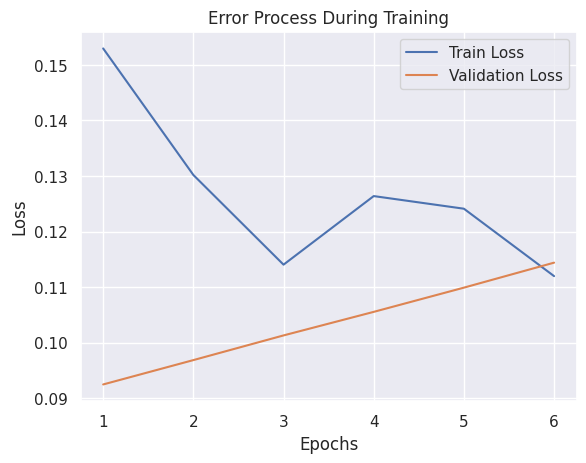

In [ ]:
te.training_error()

In [ ]:
te.random_plot(0)

### Load

In [ ]:
model_dense = mine_load_model(project_tag = CMAPSS_IN,MODEL_NAME = 'Dense')

number 0: 2023_06_01_Dense.h5
-------> Model path choose: /content/drive/MyDrive/ColabProjects/PdM/model/CMAPSS_instance/Dense/2023_06_01_Dense.h5


### Evaluate
Contains:
* Run predict on test set
* Record errors on a dataframe or further compair of difference models

## LSTM

### Define model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint , EarlyStopping

from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [ ]:
model_LSTM = Sequential()
model_LSTM.add(InputLayer((14, 1)))
model_LSTM.add(LSTM(units = 64,return_sequences=True))
model_LSTM.add(Dense(10, 'relu'))
model_LSTM.add(Dropout(rate=0.3))
model_LSTM.add(Dense(1))

model_LSTM.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 14, 64)            16896     
                                                                 
 dense_34 (Dense)            (None, 14, 10)            650       
                                                                 
 dropout_9 (Dropout)         (None, 14, 10)            0         
                                                                 
 dense_35 (Dense)            (None, 14, 1)             11        
                                                                 
Total params: 17,557
Trainable params: 17,557
Non-trainable params: 0
_________________________________________________________________


In [ ]:
MODEL_NAME = 'LSTM'
# Save folder
import time
current_time = time.strftime("%Y_%m_%d")
model_time_name = '%s_%s.h5'%(current_time,MODEL_NAME)
print(model_time_name)
SAVE_LSTM = os.path.join(CMAPSS_IN['SAVE_MODEL'],MODEL_NAME,model_time_name)
print(SAVE_LSTM)

2023_06_01_LSTM.h5
/content/drive/MyDrive/ColabProjects/PdM/model/CMAPSS_instance/LSTM/2023_06_01_LSTM.h5


In [ ]:
# Check point
cp = ModelCheckpoint(SAVE_LSTM, save_best_only=True)
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
# Complile
model_LSTM.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.00001), metrics=[RootMeanSquaredError()])

### Train

In [ ]:
history_LSTM = model_LSTM.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[cp, early_stopping])

Epoch 1/100
7/7 [==============================] - 9s 381ms/step - loss: 0.4966 - root_mean_squared_error: 0.7057 - val_loss: 0.0674 - val_root_mean_squared_error: 0.2696
Epoch 2/100
7/7 [==============================] - 0s 53ms/step - loss: 0.4959 - root_mean_squared_error: 0.7059 - val_loss: 0.0666 - val_root_mean_squared_error: 0.2681
Epoch 3/100
7/7 [==============================] - 0s 60ms/step - loss: 0.4933 - root_mean_squared_error: 0.7019 - val_loss: 0.0658 - val_root_mean_squared_error: 0.2665
Epoch 4/100
7/7 [==============================] - 0s 67ms/step - loss: 0.4924 - root_mean_squared_error: 0.7019 - val_loss: 0.0650 - val_root_mean_squared_error: 0.2650
Epoch 5/100
7/7 [==============================] - 1s 130ms/step - loss: 0.4908 - root_mean_squared_error: 0.6995 - val_loss: 0.0642 - val_root_mean_squared_error: 0.2634
Epoch 6/100
7/7 [==============================] - 1s 138ms/step - loss: 0.4878 - root_mean_squared_error: 0.6927 - val_loss: 0.0634 - val_root_mean

In [ ]:
model_LSTM.save(SAVE_LSTM)

### Load

### Evaluate

## New model

### Define model

### Train

### Load

### Evaluate